In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
src_path='../src'
if not src_path in sys.path:
    sys.path.insert(1,src_path)
from preposessing import *
import matplotlib
from utils_OB import *
import mat73
import pymatreader
import pandas as pd
import scipy as sp

Could not import mat 73. Intall width "pip install mat73" if class "import_file" is to be used.


ModuleNotFoundError: No module named 'mat73'

In [2]:
path="D:\ProcessedData_Hardanger_mat\HB141M-2013-12-06_17-20-55.mat"

drop=['active_components', 'adjusted_samplerate', 'channel', 'comments', 'firmware', 'internal_samplerate', 'location', 'no_of_components', 'orientation', 'position', 'rotation', 'serial', 'statistical_info', 'transformation_matrix', 'transformation_matrix_2', 'triggering', 'triggertype', 'type', 'wanted_orientation', 'wanted_rotation','sensor_setup','component_no', 'data_quality', 'adjusted_data', 'measurement_type', 'measurement_unit', 'valid_range', 'mean', 'kurtosis', 'standard_deviation', 'skewness',
      'postlen', 'sensor_setup', 'trigcode', 'coordinate_system', 'references', 'geographic_location', 'structure_name', 'x_axis', 'latitude', 'datenumber', 'origin', 'starttime', 'title', 'datalogger', 'z_axis', 'samplerate', 'y_axis', 'structure_type', 'comments', 'longitude', 'prelen']


variable_names=['recording','sensor','general']
ignore_fields=[]
file=pymatreader.read_mat(path,variable_names,drop)


In [3]:
recording=file.get('recording')
print(recording.keys())
sensor=recording.get('sensor')
print(sensor.keys())
print(sensor['sensor_name'])
component=sensor['component']
print(component[-1])
A9=component[-1]
A9_raw=(A9.get('raw_data'))

H1_east=component[0]

dur=recording.get('general').get('duration')
print(len(A9_raw[0])/dur)

print(recording.get('general').keys())

dict_keys(['sensor', 'general'])
dict_keys(['sensor_name', 'component'])
['H1 East', 'H1 Vest', 'H2 Vest', 'H3 East', 'H3 Vest', 'H4 East', 'H4 Vest', 'H5 East', 'H5 Vest', 'H6 East', 'H6 Vest', 'H7 East', 'H7 Vest', 'H8 East', 'H9 East', 'H9 Vest', 'H10 East', 'H10 Vest', 'H11 East', 'H11 Vest', 'A1', 'A2', 'A3', 'A4', 'A6', 'A7', 'A8', 'A9']
{'component_no': [1.0, 2.0, 3.0, 4.0], 'measurement_unit': ['deg', 'm/s', 'm/s', 'degC'], 'standard_deviation': [32.60211160860457, 2.3026604902664403, 1.2265919861286194, 0.16040446788366883], 'valid_range': [{'ATTRIBUTE': {'relative': 'false'}, 'CONTENT': array([-180.,  540.])}, {'ATTRIBUTE': {'relative': 'false'}, 'CONTENT': array([-50.,  50.])}, {'ATTRIBUTE': {'relative': 'false'}, 'CONTENT': array([-50.,  50.])}, {'ATTRIBUTE': {'relative': 'false'}, 'CONTENT': array([-50.,  50.])}], 'raw_data': [array([110., 110., 110., ..., 112., 112.,  91.]), array([5.46, 5.46, 5.46, ..., 1.67, 1.67, 1.9 ]), array([-1.32, -1.32, -1.32, ...,  0.74,  0.74,  

In [2]:
import time
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

def import_and_downsample(path):
    drop=['active_components', 'adjusted_samplerate', 'channel', 'comments', 'firmware', 'internal_samplerate', 'location', 'no_of_components', 'orientation', 'position', 'rotation', 'serial', 'statistical_info', 'transformation_matrix_2', 'triggering', 'triggertype', 'type', 'wanted_orientation', 'wanted_rotation','sensor_setup','component_no', 'data_quality', 'adjusted_data', 'measurement_type', 'measurement_unit', 'valid_range', 'mean', 'kurtosis', 'standard_deviation', 'skewness',
    'postlen', 'sensor_setup', 'trigcode', 'coordinate_system', 'references', 'geographic_location', 'structure_name', 'x_axis', 'latitude', 'datenumber', 'origin', 'starttime', 'title', 'datalogger', 'z_axis', 'samplerate', 'y_axis', 'structure_type', 'comments', 'longitude', 'prelen']


    variable_names=['recording','sensor','general']
    file=pymatreader.read_mat(path,variable_names,drop)

    recording=file.get('recording')
    sensor=recording.get('sensor')
    component=sensor.get('component')

    #--------- new
    t_matrix=sensor.get('transformation_matrix')
    # print(t_matrix)
    #---------
    dataframe=pd.DataFrame()
    quality=True

    for i in range(len(component)):
        if quality:
            comp=component[i]
            sn=sensor['sensor_name'][i]
            names_ac=[sn+'_x',sn+'_y',sn+'_z']
            names_wind=[
                sn+'_angel',sn+'_horizontal',sn+'_vertical',sn+'_temperature',
                sn+'_mean_wind',sn+'_mean_temp']
            rd=comp.get('raw_data')
            start_ix=len(rd[0])//3
            stop_ix=2*len(rd[0])//3

            if sn[0]=='H':
                for j in [0,1,2]:
                    # t0=time.time()
                    # print('\nt0: ',t0)


                    signal=rd[j][start_ix:stop_ix]*t_matrix[i][j,j]
                    signal=sp.signal.detrend(signal)
                    # print('detrend: ',time.time()-t0)
                    #-------------------------------------
                    # nytt
                    std=np.std(signal)
                    # print('std: ',time.time()-t0)
                    signal=np.where(np.abs(signal) > 5*std,np.nan,signal)
                    # print('nans: ',time.time()-t0)
                    signal=pd.Series(signal).interpolate()
                    # print('interpolate: ',time.time()-t0)
                    #-------------------------------------
                    signal=sp.signal.decimate(signal,10)
                    
                    signal=sp.signal.decimate(signal,4) ## nytt, endra fra 40 til 10 + 4
                    # print('decimate: ',time.time()-t0)
                    quality_comp=comp.get('data_quality')[j]
                    if not 'acceptable' in quality_comp and (
                        'good' not in quality_comp):
                        # print('sensor ',quality_comp)
                        quality=False
                        return 'acc. '+str(quality_comp),quality
                    
            
                    dataframe[names_ac[j]]=signal
            if sn[0]=='A':
                for j in [0,1,2,3]:
                    signal=rd[j][start_ix:stop_ix]
                    #-------------------------------------
                    # nytt
                    std=np.std(signal)
                    signal=np.where(np.abs(signal) > 5*std,np.nan,signal)
                    signal=pd.Series(signal).interpolate()
                    if j==1:
                        mean_wind=np.nanmean(signal)

                    elif j==3:
                        mean_temp=np.nanmean(signal)

                    #-------------------------------------
                    signal=sp.signal.decimate(signal,10)
                    signal=sp.signal.decimate(signal,4) ## nytt, endra fra 40 

                    quality_comp=comp.get('data_quality')[j]
                    # fjern? ----------------------------------------
                    if not 'acceptable' in quality_comp and(
                        'good' not in quality_comp):
                        dataframe[names_wind[j]]=np.nan
                    #     # print('wind ',quality_comp)
                    #     quality=False
                    #     return 'wind '+str(quality_comp),quality
                    #------------------------------------------------
                    
                    dataframe[names_wind[j]]=signal

                dataframe[sn+'_mean_temp']=mean_temp
                dataframe[sn+'_mean_wind']=mean_wind
        dataframe=dataframe.copy()
# horizontal',sn+'_vertical',sn+'_temperature'


    duration = recording.get('general').get('duration')
    time_series=np.linspace(0,duration,len(rd[0]))
    t1=time_series[start_ix]
    t2=time_series[stop_ix]
    dataframe['timeseries']=np.linspace(t1,t2,len(signal))
        

    # if not len(dataframe.columns)==93:
        # quality=False
    return dataframe,quality
        


In [4]:
def convert_folder(path_in,*args,path_out='',sorting_crit='-'):
    '''Function to convert a whole folder of .mat -files to 
    "time_segment" objects and save them as .pkl files
    arguments: 
        path_in: string 
            path of the folder with the .mat files. 
            can contain other folders, but not other file types
        
        *args: 
        path_out: string, optional
            Where to save the .pkl files. Creates a subfolder called 
            'converted_ts' in the input folder by default. 
        sorting_crit: string 
            substring of filename demanded to convert file
            eg. '2015-05' for converting all files from may 2015
            name format: HB141M-YYYY-MM-DD_HH-MM-SS.mat  '''
    if path_out == '':
        path_out=path_in+'/converted_ts/'
    try:
        os.mkdir(path_out)
    except FileExistsError:
        pass
    count=0
    errors=[]
    dir = os.listdir(path_in)
    # dir = not_ran
    dir.sort()
    dir_out=os.listdir(path_out)
    
    for entry in dir:
        try:
            # print('started: ',entry)
            # try:
            file_path=os.path.join(path_in,entry)
            # print(entry)
            if os.path.isfile(file_path) and sorting_crit in file_path:
                # if entry[:-3]+'pkl' in os.listdir(path_out):
                    if not entry[:-3]+'pkl' in dir_out:
                        #-------------
                        dataframe,quality=import_and_downsample(file_path)
                        # print((dataframe.columns))
                        # print(dataframe.head())
                        # print(quality)
                        if quality:
                            # print('lagrer')
                            pd.to_pickle(dataframe,path_out+entry[:-3]+'pkl')
                            with open('resampl_log_file.txt','a') as file:
                                file.write(str(entry[:-3])+': saved\n')
                        else: 
                            with open('resampl_log_file.txt','a') as file:
                                file.write(str(entry[:-3])+': '+str(
                                    dataframe)+'\n')
                            errors.append(entry)
        except: 
            print('failed: ',entry)
                    # count+=1
                    # if count < 10:
                    #     print(count)
                        #--------------
            # else:
            #     with open('resampl_log_file2.txt','a') as file:
            #         file.write(str(entry[:-3])+': not found in prev resample folder\n')
        # except Exception as e :
        #     print(e)
        #     errors.append(entry)
        #     continue
    # print('Errors: ',errors)    
    

### Kjør da

In [5]:
convert_folder("D:/ProcessedData_Hardanger_mat",path_out="../../5hz_resampled_int_tans/",sorting_crit='-' )

c:\Users\olebj\miniconda3\lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


failed:  HB141M-2014-12-06_00-41-52.mat
failed:  HB141M-2014-12-06_01-22-38.mat
failed:  HB141M-2014-12-06_01-53-57.mat
failed:  HB141M-2014-12-06_04-58-38.mat


c:\Users\olebj\miniconda3\lib\site-packages\pymatreader\utils.py:122: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


failed:  HB141M-2016-01-30_20-00-00.mat


In [18]:
    ac_channels=['H1 East_x', 'H1 East_y', 'H1 East_z', 'H1 Vest_x',
     'H1 Vest_y',
       'H1 Vest_z', 'H2 Vest_x', 'H2 Vest_y', 'H2 Vest_z', 'H3 East_x',
       'H3 East_y', 'H3 East_z', 'H3 Vest_x', 'H3 Vest_y', 'H3 Vest_z',
       'H4 East_x', 'H4 East_y', 'H4 East_z', 'H4 Vest_x', 'H4 Vest_y',
       'H4 Vest_z', 'H5 East_x', 'H5 East_y', 'H5 East_z', 'H5 Vest_x',
       'H5 Vest_y', 'H5 Vest_z', 'H6 East_x', 'H6 East_y', 'H6 East_z',
       'H6 Vest_x', 'H6 Vest_y', 'H6 Vest_z', 'H7 East_x', 'H7 East_y',
       'H7 East_z', 'H7 Vest_x', 'H7 Vest_y', 'H7 Vest_z', 'H8 East_x',
       'H8 East_y', 'H8 East_z', 'H9 East_x', 'H9 East_y', 'H9 East_z',
       'H9 Vest_x', 'H9 Vest_y', 'H9 Vest_z', 'H10 East_x', 'H10 East_y',
       'H10 East_z', 'H10 Vest_x', 'H10 Vest_y', 'H10 Vest_z', 'H11 East_x',
       'H11 East_y', 'H11 East_z', 'H11 Vest_x', 'H11 Vest_y', 'H11 Vest_z',]

In [25]:
names_2=os.listdir('../../../5hz_resampled_int_tans/')
print(len(names_2))

path='../../../5hz_resampled_int_tans/'
# dataframe=pd.read_pickle(path)
# print(dataframe.keys())

count=0
for name in names_2:
    dataframe=pd.read_pickle(path+name)
    if not all(np.isin( ac_channels,dataframe.keys())):
        os.remove(path+name)
        
print(count)

# dataframe=pd.read_pickle(path+names_2[20])
# for key in dataframe.keys():
#     print(key)

4009
0


In [8]:
temp_sensors=['A1_temperature','A2_temperature','A3_temperature','A4_temperature',
              'A5_temperature','A6_temperature','A7_temperature',
              'A8_temperature','A9_temperature']

df_temp=dataframe.filter(temp_sensors).copy()
df_temp=df_temp.mean(axis=0)
print(df_temp.head())
df_temp.info()

temp_sensors.insert(0,'dato')
# print(columns)

DF_temperature=pd.DataFrame(columns=temp_sensors)
print(DF_temperature.head())
DF_temperature.append(df_temp,ignore_index=True)

A1_temperature    3.890042
A2_temperature   -1.326429
A3_temperature    2.605079
A4_temperature    5.818947
A6_temperature    4.249717
dtype: float64
<class 'pandas.core.series.Series'>
Index: 8 entries, A1_temperature to A9_temperature
Series name: None
Non-Null Count  Dtype  
--------------  -----  
8 non-null      float64
dtypes: float64(1)
memory usage: 128.0+ bytes
Empty DataFrame
Columns: [dato, A1_temperature, A2_temperature, A3_temperature, A4_temperature, A5_temperature, A6_temperature, A7_temperature, A8_temperature, A9_temperature]
Index: []


C:\Users\olebj\AppData\Local\Temp\ipykernel_18268\4246057696.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_temperature.append(df_temp,ignore_index=True)


,dato,A1_temperature,A2_temperature,A3_temperature,A4_temperature,A5_temperature,A6_temperature,A7_temperature,A8_temperature,A9_temperature
0,NaN,3.890042,-1.326429,2.605079,5.818947,NaN,4.249717,6.0035,2.246559,4.612059


# ----------

In [9]:
not_ran=['HB141M-2015-09-14_21-59-17.mat', 'HB141M-2015-09-15_00-22-44.mat', 'HB141M-2015-10-02_06-16-48.mat', 'HB141M-2015-01-10_12-25-21.mat', 'HB141M-2015-01-10_13-16-09.mat', 'HB141M-2015-01-10_14-49-09.mat', 'HB141M-2015-01-10_15-20-08.mat', 'HB141M-2015-01-10_15-51-08.mat', 'HB141M-2015-01-10_16-22-08.mat', 'HB141M-2015-01-10_16-53-08.mat', 'HB141M-2015-01-10_17-24-08.mat', 'HB141M-2015-01-10_17-55-08.mat', 'HB141M-2015-01-10_21-01-48.mat', 'HB141M-2015-01-10_22-03-48.mat', 'HB141M-2015-01-10_22-34-48.mat', 'HB141M-2015-01-10_23-05-48.mat', 'HB141M-2015-01-10_23-36-48.mat', 'HB141M-2015-01-11_00-07-48.mat', 'HB141M-2015-01-11_00-38-48.mat', 'HB141M-2015-01-11_02-11-48.mat', 'HB141M-2015-01-11_03-13-48.mat', 'HB141M-2015-01-11_03-44-48.mat', 'HB141M-2015-01-11_04-46-48.mat', 'HB141M-2015-01-11_05-17-48.mat', 'HB141M-2015-01-11_05-48-48.mat', 'HB141M-2015-01-11_06-19-47.mat', 'HB141M-2015-01-11_06-50-47.mat', 'HB141M-2015-01-11_07-30-21.mat', 'HB141M-2015-01-11_08-01-28.mat', 'HB141M-2015-01-11_08-37-43.mat', 'HB141M-2015-01-11_14-08-40.mat', 'HB141M-2015-01-12_13-06-36.mat', 'HB141M-2015-01-12_13-57-41.mat', 'HB141M-2015-01-12_20-19-11.mat', 'HB141M-2015-01-12_22-54-25.mat', 'HB141M-2015-01-16_14-00-25.mat', 'HB141M-2015-01-16_14-31-25.mat', 'HB141M-2015-01-16_15-02-25.mat', 'HB141M-2015-01-16_16-53-12.mat', 'HB141M-2015-01-16_17-46-17.mat', 'HB141M-2015-01-16_18-17-17.mat', 'HB141M-2015-01-16_18-48-35.mat', 'HB141M-2015-01-16_19-19-35.mat', 'HB141M-2015-01-16_19-50-35.mat', 'HB141M-2015-01-29_13-58-45.mat', 'HB141M-2015-01-29_15-27-57.mat', 'HB141M-2015-01-31_08-08-40.mat', 'HB141M-2015-02-07_05-31-21.mat', 'HB141M-2015-02-07_06-02-21.mat', 'HB141M-2015-02-07_06-33-21.mat', 'HB141M-2015-02-07_07-04-21.mat', 'HB141M-2015-02-07_07-35-21.mat', 'HB141M-2015-02-07_08-06-21.mat', 'HB141M-2015-02-07_08-37-39.mat', 'HB141M-2015-02-07_09-09-27.mat', 'HB141M-2015-02-07_09-40-27.mat', 'HB141M-2015-02-07_10-11-27.mat', 'HB141M-2015-02-07_10-44-52.mat', 'HB141M-2015-02-07_11-15-52.mat', 'HB141M-2015-02-07_11-46-52.mat', 'HB141M-2015-02-07_12-17-52.mat', 'HB141M-2015-02-07_12-49-42.mat', 'HB141M-2015-02-07_13-20-42.mat', 'HB141M-2015-02-07_13-55-37.mat', 'HB141M-2015-02-07_14-27-23.mat', 'HB141M-2015-02-07_14-58-23.mat', 'HB141M-2015-02-07_15-29-23.mat', 'HB141M-2015-02-07_16-08-16.mat', 'HB141M-2015-02-07_16-39-16.mat', 'HB141M-2015-02-07_17-13-18.mat', 'HB141M-2015-02-07_17-47-22.mat', 'HB141M-2015-02-07_19-33-45.mat', 'HB141M-2015-02-08_00-15-23.mat', 'HB141M-2015-02-17_16-37-08.mat', 'HB141M-2015-02-17_17-08-24.mat', 'HB141M-2015-02-17_17-39-24.mat', 'HB141M-2015-02-17_18-36-18.mat', 'HB141M-2015-02-17_19-07-18.mat', 'HB141M-2015-02-17_19-38-18.mat', 'HB141M-2015-02-17_20-09-18.mat', 'HB141M-2015-02-17_20-40-18.mat', 'HB141M-2015-02-17_21-11-18.mat', 'HB141M-2015-02-17_21-42-48.mat', 'HB141M-2015-02-17_22-13-48.mat', 'HB141M-2015-02-17_22-45-05.mat', 'HB141M-2015-02-17_23-16-05.mat', 'HB141M-2015-02-18_00-27-17.mat', 'HB141M-2015-02-18_01-49-00.mat', 'HB141M-2015-02-18_02-23-19.mat', 'HB141M-2015-02-18_03-05-41.mat', 'HB141M-2015-02-18_03-38-15.mat', 'HB141M-2015-02-19_06-55-12.mat', 'HB141M-2015-02-19_07-46-59.mat', 'HB141M-2015-02-19_08-38-20.mat', 'HB141M-2015-02-19_09-11-35.mat', 'HB141M-2015-02-19_23-33-26.mat', 'HB141M-2015-03-08_09-26-45.mat', 'HB141M-2015-03-08_10-02-09.mat', 'HB141M-2015-03-08_10-38-28.mat', 'HB141M-2015-03-08_11-15-08.mat', 'HB141M-2015-03-08_12-13-07.mat', 'HB141M-2015-03-08_16-05-47.mat', 'HB141M-2015-03-08_23-40-05.mat', 'HB141M-2015-03-09_00-11-05.mat', 'HB141M-2015-03-09_02-53-47.mat', 'HB141M-2015-03-10_04-34-30.mat', 'HB141M-2015-03-10_06-20-31.mat', 'HB141M-2015-03-10_09-26-31.mat', 'HB141M-2015-03-10_10-28-31.mat', 'HB141M-2015-03-10_10-59-31.mat', 'HB141M-2015-03-10_11-30-31.mat', 'HB141M-2015-03-10_12-01-31.mat', 'HB141M-2015-03-10_12-32-31.mat', 'HB141M-2015-03-10_13-03-31.mat', 'HB141M-2015-03-10_14-05-31.mat', 'HB141M-2015-03-10_14-36-31.mat', 'HB141M-2015-03-10_15-07-31.mat', 'HB141M-2015-03-10_15-38-31.mat', 'HB141M-2015-03-10_16-09-31.mat', 'HB141M-2015-03-21_05-46-57.mat', 'HB141M-2015-04-11_19-44-45.mat', 'HB141M-2015-04-11_20-17-43.mat', 'HB141M-2015-04-11_21-04-10.mat', 'HB141M-2015-04-12_05-36-50.mat', 'HB141M-2015-04-12_11-26-00.mat', 'HB141M-2015-04-12_20-38-41.mat', 'HB141M-2015-04-12_21-23-18.mat', 'HB141M-2015-04-12_22-27-57.mat', 'HB141M-2015-04-12_23-17-00.mat', 'HB141M-2015-04-13_00-00-05.mat', 'HB141M-2015-04-13_04-36-59.mat', 'HB141M-2015-04-13_06-47-01.mat', 'HB141M-2015-04-13_07-20-24.mat', 'HB141M-2015-04-13_07-51-24.mat', 'HB141M-2015-04-13_08-31-31.mat', 'HB141M-2015-04-14_22-55-34.mat', 'HB141M-2015-04-15_21-34-14.mat', 'HB141M-2015-04-23_00-06-42.mat', 'HB141M-2015-04-25_20-41-16.mat', 'HB141M-2015-05-18_19-16-12.mat', 'HB141M-2015-05-18_19-47-12.mat', 'HB141M-2015-05-18_20-19-13.mat', 'HB141M-2015-05-18_20-50-13.mat', 'HB141M-2015-05-18_22-29-28.mat', 'HB141M-2015-05-18_23-09-14.mat', 'HB141M-2015-05-18_23-40-31.mat', 'HB141M-2015-05-19_00-16-32.mat', 'HB141M-2015-05-19_01-41-54.mat', 'HB141M-2015-05-19_02-15-45.mat', 'HB141M-2015-05-19_02-47-46.mat', 'HB141M-2015-05-19_03-18-46.mat', 'HB141M-2015-05-19_03-49-46.mat', 'HB141M-2015-05-19_04-20-46.mat', 'HB141M-2015-05-19_05-00-19.mat', 'HB141M-2015-05-22_11-22-07.mat', 'HB141M-2015-05-22_11-59-28.mat', 'HB141M-2015-05-22_12-53-14.mat', 'HB141M-2015-05-22_13-25-32.mat', 'HB141M-2015-05-22_13-57-02.mat', 'HB141M-2015-05-22_14-38-20.mat', 'HB141M-2015-05-22_15-15-44.mat', 'HB141M-2015-05-22_16-27-35.mat', 'HB141M-2015-05-22_16-58-35.mat', 'HB141M-2015-05-22_20-25-10.mat', 'HB141M-2015-05-22_21-05-05.mat', 'HB141M-2015-05-22_23-15-26.mat', 'HB141M-2015-05-22_23-46-26.mat', 'HB141M-2015-05-23_00-17-58.mat', 'HB141M-2015-05-23_00-48-57.mat', 'HB141M-2015-05-23_01-20-33.mat', 'HB141M-2015-05-23_01-51-33.mat', 'HB141M-2015-05-23_02-22-33.mat', 'HB141M-2015-05-23_03-02-35.mat', 'HB141M-2015-05-23_04-07-57.mat', 'HB141M-2015-05-23_04-49-45.mat', 'HB141M-2015-06-01_06-27-18.mat', 'HB141M-2015-06-01_06-58-18.mat', 'HB141M-2015-06-01_07-30-05.mat', 'HB141M-2015-06-01_08-07-28.mat', 'HB141M-2015-06-01_09-09-34.mat', 'HB141M-2015-06-01_09-40-34.mat', 'HB141M-2015-06-01_10-11-34.mat', 'HB141M-2015-06-01_10-42-34.mat', 'HB141M-2015-06-01_11-13-33.mat', 'HB141M-2015-06-01_11-48-02.mat', 'HB141M-2015-06-01_13-21-02.mat', 'HB141M-2015-06-01_14-18-26.mat', 'HB141M-2015-06-01_15-48-14.mat', 'HB141M-2015-07-06_16-45-06.mat', 'HB141M-2015-07-06_17-29-48.mat', 'HB141M-2015-07-06_19-47-06.mat', 'HB141M-2015-07-22_08-35-48.mat', 'HB141M-2015-08-03_22-48-53.mat', 'HB141M-2015-08-03_23-19-53.mat', 'HB141M-2015-08-03_23-50-53.mat', 'HB141M-2015-08-04_00-23-13.mat', 'HB141M-2015-08-04_00-54-13.mat', 'HB141M-2015-08-04_01-25-13.mat', 'HB141M-2015-08-04_01-56-13.mat', 'HB141M-2015-08-04_02-27-13.mat', 'HB141M-2015-08-04_02-58-13.mat', 'HB141M-2015-08-04_03-29-13.mat', 'HB141M-2015-08-04_04-00-20.mat', 'HB141M-2015-08-04_04-44-48.mat', 'HB141M-2015-08-04_06-19-40.mat', 'HB141M-2015-08-04_06-51-50.mat', 'HB141M-2015-08-04_07-48-11.mat', 'HB141M-2015-08-04_08-21-33.mat', 'HB141M-2015-08-04_09-47-14.mat', 'HB141M-2015-08-04_10-19-57.mat', 'HB141M-2015-08-04_10-57-32.mat', 'HB141M-2015-08-04_11-35-31.mat', 'HB141M-2015-08-04_12-09-55.mat', 'HB141M-2015-08-04_12-44-28.mat', 'HB141M-2015-08-14_19-06-41.mat', 'HB141M-2015-08-14_19-45-59.mat', 'HB141M-2015-08-14_20-59-33.mat', 'HB141M-2015-08-14_23-24-57.mat', 'HB141M-2015-08-15_00-32-07.mat', 'HB141M-2015-08-15_01-08-07.mat', 'HB141M-2015-08-15_02-45-22.mat', 'HB141M-2015-08-15_03-16-22.mat', 'HB141M-2015-08-15_03-47-22.mat', 'HB141M-2015-08-15_06-06-02.mat', 'HB141M-2015-08-15_07-38-06.mat', 'HB141M-2015-08-15_10-57-40.mat', 'HB141M-2015-08-15_17-38-14.mat', 'HB141M-2015-08-15_21-32-53.mat', 'HB141M-2015-08-16_00-29-32.mat', 'HB141M-2015-08-16_01-30-32.mat', 'HB141M-2015-08-16_04-46-44.mat', 'HB141M-2015-08-16_05-47-16.mat', 'HB141M-2015-08-16_06-30-24.mat', 'HB141M-2015-08-16_07-12-19.mat', 'HB141M-2015-08-16_07-50-40.mat', 'HB141M-2015-08-16_08-49-04.mat', 'HB141M-2015-08-16_09-28-27.mat', 'HB141M-2015-08-16_10-00-19.mat', 'HB141M-2015-08-16_10-31-19.mat', 'HB141M-2015-08-16_11-02-33.mat', 'HB141M-2015-08-16_11-33-33.mat', 'HB141M-2015-08-16_13-16-24.mat', 'HB141M-2015-08-16_13-54-32.mat', 'HB141M-2015-08-19_09-50-49.mat', 'HB141M-2015-08-21_00-37-35.mat', 'HB141M-2015-08-24_20-02-08.mat', 'HB141M-2015-08-25_02-09-25.mat', 'HB141M-2015-08-25_02-55-28.mat', 'HB141M-2015-08-25_03-29-09.mat', 'HB141M-2015-08-25_04-02-43.mat', 'HB141M-2015-08-25_04-34-17.mat', 'HB141M-2015-08-25_05-06-40.mat', 'HB141M-2015-09-13_00-36-24.mat', 'HB141M-2015-09-13_20-48-36.mat', 'HB141M-2015-09-14_08-46-25.mat', 'HB141M-2015-09-14_09-50-37.mat', 'HB141M-2015-10-02_13-31-41.mat', 'HB141M-2015-10-02_14-02-41.mat', 'HB141M-2015-10-02_14-33-41.mat', 'HB141M-2015-10-02_15-04-41.mat', 'HB141M-2015-10-02_15-35-41.mat', 'HB141M-2015-10-02_16-06-41.mat', 'HB141M-2015-10-02_17-22-28.mat', 'HB141M-2015-10-22_09-08-30.mat', 'HB141M-2015-10-22_12-31-26.mat', 'HB141M-2015-10-22_14-41-55.mat', 'HB141M-2015-10-22_15-12-55.mat', 'HB141M-2015-10-22_15-48-13.mat', 'HB141M-2015-10-22_16-19-13.mat', 'HB141M-2015-10-22_16-50-13.mat', 'HB141M-2015-10-22_17-22-42.mat', 'HB141M-2015-10-22_18-20-26.mat', 'HB141M-2015-10-22_18-51-26.mat', 'HB141M-2015-10-22_19-22-26.mat', 'HB141M-2015-10-22_19-56-16.mat', 'HB141M-2015-10-22_20-37-13.mat', 'HB141M-2015-10-22_21-15-11.mat', 'HB141M-2015-10-22_21-54-02.mat', 'HB141M-2015-10-30_08-14-04.mat', 'HB141M-2015-11-09_04-32-31.mat', 'HB141M-2015-11-09_07-46-49.mat', 'HB141M-2015-11-09_18-20-20.mat', 'HB141M-2015-11-09_19-23-26.mat', 'HB141M-2015-11-09_19-57-37.mat', 'HB141M-2015-11-09_20-49-34.mat', 'HB141M-2015-11-09_21-23-42.mat', 'HB141M-2015-11-09_22-14-23.mat', 'HB141M-2015-11-09_22-52-25.mat', 'HB141M-2015-11-09_23-24-02.mat', 'HB141M-2015-11-10_00-10-25.mat', 'HB141M-2015-11-16_05-03-18.mat', 'HB141M-2015-11-16_10-35-36.mat', 'HB141M-2015-11-30_06-57-44.mat', 'HB141M-2015-11-30_07-28-44.mat', 'HB141M-2015-11-30_10-23-42.mat', 'HB141M-2015-11-30_17-17-26.mat', 'HB141M-2015-12-01_02-53-23.mat', 'HB141M-2015-12-01_03-34-22.mat', 'HB141M-2015-12-01_07-39-13.mat', 'HB141M-2015-12-01_09-21-29.mat', 'HB141M-2015-12-04_00-54-11.mat', 'HB141M-2015-12-04_01-26-03.mat', 'HB141M-2015-12-04_02-10-24.mat', 'HB141M-2015-12-04_03-16-30.mat', 'HB141M-2015-12-04_03-53-15.mat', 'HB141M-2015-12-04_04-24-15.mat', 'HB141M-2015-12-04_08-35-19.mat', 'HB141M-2015-12-04_09-15-58.mat', 'HB141M-2015-12-04_09-58-35.mat', 'HB141M-2015-12-05_08-37-07.mat', 'HB141M-2015-12-05_09-13-17.mat', 'HB141M-2015-12-05_11-40-33.mat', 'HB141M-2015-12-05_13-04-42.mat', 'HB141M-2015-12-05_13-47-29.mat', 'HB141M-2015-12-09_05-44-53.mat', 'HB141M-2015-12-10_08-41-08.mat', 'HB141M-2015-12-10_15-03-20.mat', 'HB141M-2015-12-10_17-38-41.mat', 'HB141M-2015-12-10_18-31-32.mat', 'HB141M-2015-12-10_23-21-32.mat', 'HB141M-2015-12-18_13-30-00.mat', 'HB141M-2015-12-18_14-00-00.mat', 'HB141M-2015-12-18_14-30-00.mat', 'HB141M-2015-12-18_15-00-00.mat', 'HB141M-2015-12-18_15-30-00.mat', 'HB141M-2015-12-18_16-00-00.mat', 'HB141M-2015-12-18_16-30-00.mat', 'HB141M-2015-12-18_17-00-00.mat', 'HB141M-2015-12-18_17-30-00.mat', 'HB141M-2015-12-18_18-00-00.mat', 'HB141M-2015-12-18_18-30-00.mat', 'HB141M-2015-12-20_13-30-00.mat', 'HB141M-2015-12-21_13-00-00.mat', 'HB141M-2015-12-22_04-00-00.mat', 'HB141M-2015-12-23_15-30-00.mat', 'HB141M-2015-12-23_16-00-00.mat', 'HB141M-2015-12-23_16-30-00.mat', 'HB141M-2015-12-23_17-00-00.mat', 'HB141M-2015-12-23_17-30-00.mat', 'HB141M-2015-12-23_18-00-00.mat', 'HB141M-2015-12-23_19-00-00.mat', 'HB141M-2015-12-23_19-30-00.mat', 'HB141M-2015-12-23_20-00-00.mat', 'HB141M-2015-12-24_16-30-00.mat', 'HB141M-2015-12-24_17-00-00.mat', 'HB141M-2015-12-24_18-00-00.mat', 'HB141M-2015-12-24_18-30-00.mat', 'HB141M-2015-12-24_19-00-00.mat', 'HB141M-2015-12-24_19-30-00.mat', 'HB141M-2015-12-24_20-00-00.mat', 'HB141M-2015-12-24_21-00-00.mat', 'HB141M-2015-12-24_21-30-00.mat', 'HB141M-2015-12-25_00-00-00.mat', 'HB141M-2015-12-25_00-30-00.mat', 'HB141M-2015-12-25_06-00-00.mat', 'HB141M-2015-12-25_06-30-00.mat', 'HB141M-2015-12-25_07-30-00.mat', 'HB141M-2015-12-25_08-00-00.mat', 'HB141M-2015-12-25_08-30-00.mat', 'HB141M-2015-12-25_09-00-00.mat', 'HB141M-2015-12-25_09-30-00.mat', 'HB141M-2015-12-25_10-00-00.mat', 'HB141M-2015-12-25_10-30-00.mat', 'HB141M-2015-12-25_11-00-00.mat', 'HB141M-2015-12-25_11-30-00.mat', 'HB141M-2015-12-25_12-00-00.mat', 'HB141M-2015-12-25_12-30-00.mat', 'HB141M-2015-12-25_18-30-00.mat', 'HB141M-2016-01-26_00-48-32.mat', 'HB141M-2016-01-26_04-26-58.mat', 'HB141M-2016-01-26_06-27-30.mat', 'HB141M-2016-01-29_16-00-00.mat', 'HB141M-2016-01-29_17-00-00.mat', 'HB141M-2016-01-29_18-00-00.mat', 'HB141M-2016-01-29_18-30-00.mat', 'HB141M-2016-01-29_19-00-00.mat', 'HB141M-2016-01-29_23-00-00.mat', 'HB141M-2016-01-29_23-30-00.mat', 'HB141M-2016-01-30_00-00-00.mat', 'HB141M-2016-01-30_00-30-00.mat', 'HB141M-2016-01-30_05-30-00.mat', 'HB141M-2016-01-30_08-00-00.mat', 'HB141M-2016-01-30_08-30-00.mat', 'HB141M-2016-01-30_09-00-00.mat', 'HB141M-2016-01-30_09-30-00.mat', 'HB141M-2016-01-30_10-00-00.mat', 'HB141M-2016-01-30_10-30-00.mat', 'HB141M-2016-01-30_11-00-00.mat', 'HB141M-2016-01-30_22-30-00.mat', 'HB141M-2016-01-31_00-00-00.mat', 'HB141M-2016-01-31_00-30-00.mat', 'HB141M-2016-01-31_04-00-00.mat', 'HB141M-2016-01-31_04-30-00.mat', 'HB141M-2016-01-31_05-00-00.mat', 'HB141M-2016-01-31_05-30-00.mat', 'HB141M-2016-01-31_06-30-00.mat', 'HB141M-2016-01-31_07-00-00.mat', 'HB141M-2016-01-31_07-30-00.mat', 'HB141M-2016-01-31_08-00-00.mat', 'HB141M-2016-01-31_08-30-00.mat', 'HB141M-2016-01-31_09-00-00.mat', 'HB141M-2016-01-31_22-00-00.mat', 'HB141M-2016-01-31_22-30-00.mat', 'HB141M-2016-01-31_23-00-00.mat', 'HB141M-2016-02-01_01-00-00.mat', 'HB141M-2016-02-01_03-00-00.mat', 'HB141M-2016-02-01_19-00-00.mat', 'HB141M-2016-02-01_19-30-00.mat', 'HB141M-2016-02-01_20-00-00.mat', 'HB141M-2016-02-01_20-30-00.mat', 'HB141M-2016-02-01_21-00-00.mat', 'HB141M-2016-02-01_21-30-00.mat', 'HB141M-2016-02-01_22-00-00.mat', 'HB141M-2016-02-01_23-00-00.mat', 'HB141M-2016-02-01_23-30-00.mat', 'HB141M-2016-02-02_00-00-00.mat', 'HB141M-2016-02-03_09-27-16.mat', 'HB141M-2016-02-18_00-30-55.mat', 'HB141M-2016-03-01_16-40-36.mat', 'HB141M-2016-03-27_10-45-32.mat', 'HB141M-2016-03-27_15-39-37.mat', 'HB141M-2016-03-27_16-38-38.mat', 'HB141M-2016-03-28_10-27-05.mat', 'HB141M-2016-03-28_11-32-43.mat', 'HB141M-2016-03-28_12-43-51.mat', 'HB141M-2016-03-28_15-29-35.mat', 'HB141M-2016-03-28_16-00-35.mat', 'HB141M-2016-03-28_16-32-13.mat', 'HB141M-2016-03-28_17-03-38.mat', 'HB141M-2016-03-28_17-35-44.mat', 'HB141M-2016-03-28_18-24-14.mat', 'HB141M-2016-03-28_19-35-30.mat', 'HB141M-2016-03-28_20-25-20.mat', 'HB141M-2016-03-28_20-58-29.mat', 'HB141M-2016-03-28_21-29-42.mat', 'HB141M-2016-03-28_22-00-42.mat', 'HB141M-2016-03-28_22-31-42.mat', 'HB141M-2016-03-28_23-02-42.mat', 'HB141M-2016-03-28_23-33-42.mat', 'HB141M-2016-03-29_00-04-42.mat', 'HB141M-2016-03-29_00-35-42.mat', 'HB141M-2016-03-29_01-08-39.mat', 'HB141M-2016-03-29_01-44-15.mat', 'HB141M-2016-03-29_02-26-26.mat', 'HB141M-2016-03-29_03-13-40.mat', 'HB141M-2016-03-29_03-49-57.mat', 'HB141M-2016-03-29_04-21-14.mat', 'HB141M-2016-08-08_12-22-43.mat', 'HB141M-2016-08-08_14-00-16.mat', 'HB141M-2016-08-08_14-43-17.mat', 'HB141M-2016-08-08_15-14-32.mat', 'HB141M-2016-08-09_07-34-26.mat', 'HB141M-2016-08-09_08-05-26.mat', 'HB141M-2016-08-12_21-25-06.mat', 'HB141M-2016-08-12_21-56-54.mat', 'HB141M-2016-08-12_22-30-35.mat', 'HB141M-2016-08-27_01-03-10.mat', 'HB141M-2016-08-27_01-40-35.mat', 'HB141M-2016-08-27_04-18-27.mat', 'HB141M-2016-09-29_17-44-15.mat', 'HB141M-2016-09-29_18-15-29.mat', 'HB141M-2016-09-29_21-09-07.mat', 'HB141M-2016-09-29_21-40-07.mat', 'HB141M-2016-09-30_11-04-14.mat', 'HB141M-2016-09-30_14-03-36.mat', 'HB141M-2016-10-28_02-52-49.mat', 'HB141M-2016-10-28_03-56-25.mat', 'HB141M-2016-10-28_04-39-15.mat', 'HB141M-2016-10-28_06-45-16.mat', 'HB141M-2016-10-28_07-22-15.mat', 'HB141M-2016-10-28_10-07-16.mat', 'HB141M-2016-10-28_10-54-58.mat', 'HB141M-2016-10-28_11-25-58.mat', 'HB141M-2016-10-28_12-12-40.mat', 'HB141M-2016-10-28_12-43-40.mat', 'HB141M-2016-10-28_13-16-04.mat', 'HB141M-2016-10-28_13-47-04.mat', 'HB141M-2016-10-28_14-18-04.mat', 'HB141M-2016-10-28_14-51-27.mat', 'HB141M-2016-10-28_15-26-05.mat', 'HB141M-2016-10-28_15-57-05.mat', 'HB141M-2016-10-28_16-28-30.mat', 'HB141M-2016-10-28_16-59-30.mat', 'HB141M-2016-10-28_18-13-43.mat', 'HB141M-2016-10-28_19-00-43.mat', 'HB141M-2016-10-28_19-46-40.mat', 'HB141M-2016-10-28_20-17-40.mat', 'HB141M-2016-10-28_21-21-04.mat', 'HB141M-2016-10-28_21-53-05.mat', 'HB141M-2016-10-28_22-50-51.mat', 'HB141M-2016-10-28_23-23-19.mat', 'HB141M-2016-10-28_23-54-58.mat', 'HB141M-2016-10-29_00-39-20.mat', 'HB141M-2016-10-29_01-10-20.mat', 'HB141M-2016-10-29_02-43-12.mat', 'HB141M-2016-11-05_02-13-07.mat', 'HB141M-2016-11-05_03-32-20.mat', 'HB141M-2016-11-05_04-43-50.mat', 'HB141M-2016-11-05_06-12-33.mat', 'HB141M-2016-11-05_06-52-01.mat', 'HB141M-2016-11-05_07-35-59.mat', 'HB141M-2016-11-05_09-15-33.mat', 'HB141M-2016-11-05_10-45-34.mat', 'HB141M-2016-11-05_12-54-27.mat', 'HB141M-2016-11-05_13-25-27.mat', 'HB141M-2016-11-05_13-59-14.mat', 'HB141M-2016-11-05_14-30-14.mat', 'HB141M-2016-11-05_15-01-14.mat', 'HB141M-2016-11-05_15-32-14.mat', 'HB141M-2016-11-05_16-03-26.mat', 'HB141M-2016-11-05_16-34-44.mat', 'HB141M-2016-11-05_17-05-44.mat', 'HB141M-2016-11-05_17-36-44.mat', 'HB141M-2016-11-05_18-07-44.mat', 'HB141M-2016-11-05_18-38-44.mat', 'HB141M-2016-11-05_19-09-44.mat', 'HB141M-2016-11-05_19-40-44.mat', 'HB141M-2016-11-05_20-11-44.mat', 'HB141M-2016-11-05_20-42-44.mat', 'HB141M-2016-11-05_21-13-44.mat', 'HB141M-2016-11-05_21-47-02.mat', 'HB141M-2016-11-05_22-44-37.mat', 'HB141M-2016-11-06_01-04-06.mat', 'HB141M-2016-11-06_01-38-56.mat', 'HB141M-2016-11-06_02-09-56.mat', 'HB141M-2016-11-06_02-42-42.mat', 'HB141M-2016-11-06_03-18-24.mat', 'HB141M-2016-11-06_03-49-24.mat', 'HB141M-2016-11-06_04-20-24.mat', 'HB141M-2016-11-06_04-51-24.mat', 'HB141M-2016-11-06_05-28-34.mat', 'HB141M-2016-11-06_06-06-10.mat', 'HB141M-2016-11-06_06-37-10.mat', 'HB141M-2016-11-06_07-14-08.mat', 'HB141M-2016-11-06_07-45-49.mat', 'HB141M-2016-11-06_08-17-51.mat', 'HB141M-2016-11-06_08-48-51.mat', 'HB141M-2016-11-06_09-26-38.mat', 'HB141M-2016-11-06_09-57-38.mat', 'HB141M-2016-11-06_10-39-34.mat', 'HB141M-2016-11-06_11-48-10.mat', 'HB141M-2016-11-06_12-24-25.mat', 'HB141M-2016-11-06_13-33-43.mat', 'HB141M-2016-11-06_14-42-25.mat', 'HB141M-2016-11-06_16-15-54.mat', 'HB141M-2016-11-06_16-46-54.mat', 'HB141M-2016-11-06_22-13-37.mat', 'HB141M-2016-11-06_22-46-09.mat', 'HB141M-2016-11-07_00-51-18.mat', 'HB141M-2016-11-07_04-03-18.mat', 'HB141M-2016-11-08_10-18-22.mat', 'HB141M-2016-11-08_11-25-13.mat', 'HB141M-2016-11-08_13-42-13.mat', 'HB141M-2016-11-08_14-13-13.mat', 'HB141M-2016-11-08_14-53-39.mat', 'HB141M-2016-11-08_17-20-31.mat', 'HB141M-2016-11-08_19-18-41.mat', 'HB141M-2016-11-09_02-22-11.mat', 'HB141M-2016-11-09_05-26-06.mat', 'HB141M-2016-11-09_06-24-30.mat', 'HB141M-2016-11-09_10-23-14.mat', 'HB141M-2016-11-09_14-41-40.mat', 'HB141M-2016-11-09_15-22-19.mat', 'HB141M-2016-11-09_15-58-08.mat', 'HB141M-2016-11-09_16-51-35.mat', 'HB141M-2016-11-09_19-22-46.mat', 'HB141M-2016-11-09_20-44-18.mat', 'HB141M-2016-11-09_22-24-48.mat', 'HB141M-2016-11-10_00-27-23.mat', 'HB141M-2016-11-10_01-03-56.mat', 'HB141M-2016-11-10_14-32-10.mat', 'HB141M-2016-11-10_17-14-01.mat', 'HB141M-2016-11-15_10-52-14.mat', 'HB141M-2016-11-15_11-24-34.mat', 'HB141M-2016-11-17_23-40-07.mat', 'HB141M-2016-11-18_00-46-39.mat', 'HB141M-2016-11-18_01-27-32.mat', 'HB141M-2016-11-18_01-58-38.mat', 'HB141M-2016-11-18_02-59-58.mat', 'HB141M-2016-11-22_00-29-39.mat', 'HB141M-2016-11-22_03-34-05.mat', 'HB141M-2016-11-22_04-47-57.mat', 'HB141M-2016-11-22_06-19-42.mat', 'HB141M-2016-11-22_06-54-53.mat', 'HB141M-2016-11-25_05-10-18.mat', 'HB141M-2016-11-25_05-44-48.mat', 'HB141M-2016-11-25_06-15-48.mat', 'HB141M-2016-11-25_07-22-40.mat', 'HB141M-2016-11-25_07-53-40.mat', 'HB141M-2016-11-25_08-26-40.mat', 'HB141M-2016-11-25_09-01-10.mat', 'HB141M-2016-11-25_13-48-37.mat', 'HB141M-2016-11-25_18-19-52.mat', 'HB141M-2016-11-25_19-53-40.mat', 'HB141M-2016-11-25_20-29-08.mat', 'HB141M-2016-11-25_21-00-08.mat', 'HB141M-2016-11-26_02-34-32.mat', 'HB141M-2016-11-26_03-44-52.mat', 'HB141M-2016-11-26_04-17-00.mat', 'HB141M-2016-11-26_04-48-00.mat', 'HB141M-2016-11-26_05-19-00.mat', 'HB141M-2016-11-26_05-50-00.mat', 'HB141M-2016-11-26_06-21-00.mat', 'HB141M-2016-11-26_06-57-57.mat', 'HB141M-2016-11-26_07-28-57.mat', 'HB141M-2016-11-26_07-59-57.mat', 'HB141M-2016-11-26_08-30-57.mat', 'HB141M-2016-11-26_09-34-27.mat', 'HB141M-2016-11-26_10-05-55.mat', 'HB141M-2016-11-26_10-36-55.mat', 'HB141M-2016-11-26_11-07-55.mat', 'HB141M-2016-11-26_11-38-55.mat', 'HB141M-2016-11-26_12-09-55.mat', 'HB141M-2016-11-26_12-40-55.mat', 'HB141M-2016-11-26_13-11-55.mat', 'HB141M-2016-11-26_13-42-55.mat', 'HB141M-2016-11-30_00-12-59.mat', 'HB141M-2016-11-30_00-47-04.mat', 'HB141M-2016-11-30_01-18-04.mat', 'HB141M-2016-11-30_07-26-24.mat', 'HB141M-2016-12-01_11-57-37.mat', 'HB141M-2016-12-01_13-13-23.mat', 'HB141M-2016-12-01_13-45-33.mat', 'HB141M-2016-12-01_14-23-20.mat', 'HB141M-2016-12-04_22-14-02.mat', 'HB141M-2016-12-05_07-09-24.mat', 'HB141M-2016-12-08_04-25-37.mat', 'HB141M-2016-12-08_04-56-37.mat', 'HB141M-2016-12-21_11-18-21.mat', 'HB141M-2016-12-21_18-32-40.mat', 'HB141M-2016-12-21_19-03-40.mat', 'HB141M-2016-12-21_20-15-52.mat', 'HB141M-2016-12-21_21-07-23.mat', 'HB141M-2016-12-21_21-42-47.mat', 'HB141M-2016-12-21_22-54-17.mat', 'HB141M-2016-12-22_00-00-58.mat', 'HB141M-2016-12-22_00-38-37.mat', 'HB141M-2016-12-22_01-26-01.mat', 'HB141M-2016-12-22_01-57-07.mat', 'HB141M-2016-12-22_02-28-07.mat', 'HB141M-2016-12-22_03-03-50.mat', 'HB141M-2016-12-22_03-51-45.mat', 'HB141M-2016-12-22_04-23-17.mat', 'HB141M-2016-12-22_13-17-31.mat', 'HB141M-2016-12-22_13-48-31.mat', 'HB141M-2016-12-22_14-19-31.mat', 'HB141M-2016-12-22_14-50-31.mat', 'HB141M-2016-12-22_15-28-10.mat', 'HB141M-2016-12-22_15-59-10.mat', 'HB141M-2016-12-22_18-01-51.mat', 'HB141M-2016-12-22_18-58-53.mat', 'HB141M-2016-12-22_19-41-38.mat', 'HB141M-2016-12-22_20-14-52.mat', 'HB141M-2016-12-22_21-35-02.mat', 'HB141M-2016-12-23_00-31-14.mat', 'HB141M-2016-12-23_01-44-55.mat', 'HB141M-2016-12-23_02-15-55.mat', 'HB141M-2016-12-23_02-47-40.mat', 'HB141M-2016-12-24_02-52-05.mat', 'HB141M-2016-12-24_03-58-27.mat', 'HB141M-2016-12-24_04-42-52.mat', 'HB141M-2016-12-24_10-42-20.mat', 'HB141M-2016-12-24_13-46-58.mat', 'HB141M-2016-12-24_14-20-27.mat', 'HB141M-2016-12-24_15-23-55.mat', 'HB141M-2016-12-24_16-15-29.mat', 'HB141M-2016-12-24_16-46-40.mat', 'HB141M-2016-12-24_17-17-40.mat', 'HB141M-2016-12-24_17-58-39.mat', 'HB141M-2016-12-24_18-29-39.mat', 'HB141M-2016-12-24_19-00-39.mat', 'HB141M-2016-12-24_19-31-39.mat', 'HB141M-2016-12-24_20-02-39.mat', 'HB141M-2016-12-24_20-35-46.mat', 'HB141M-2016-12-24_21-06-46.mat', 'HB141M-2016-12-24_21-37-46.mat', 'HB141M-2016-12-24_22-19-19.mat', 'HB141M-2016-12-24_22-50-29.mat', 'HB141M-2016-12-24_23-21-29.mat', 'HB141M-2016-12-24_23-52-29.mat', 'HB141M-2016-12-25_00-23-29.mat', 'HB141M-2016-12-25_01-00-19.mat', 'HB141M-2016-12-25_01-31-19.mat', 'HB141M-2016-12-25_02-02-32.mat', 'HB141M-2016-12-25_02-57-11.mat', 'HB141M-2016-12-25_04-49-16.mat', 'HB141M-2016-12-25_05-22-53.mat', 'HB141M-2016-12-25_18-35-55.mat', 'HB141M-2016-12-25_19-06-55.mat', 'HB141M-2016-12-25_19-37-55.mat', 'HB141M-2016-12-25_20-08-55.mat', 'HB141M-2016-12-25_20-41-36.mat', 'HB141M-2016-12-25_21-12-36.mat', 'HB141M-2016-12-25_21-43-36.mat', 'HB141M-2016-12-25_22-14-36.mat', 'HB141M-2016-12-25_22-45-36.mat', 'HB141M-2016-12-25_23-16-38.mat', 'HB141M-2016-12-25_23-47-38.mat', 'HB141M-2016-12-26_00-18-38.mat', 'HB141M-2016-12-26_00-49-38.mat', 'HB141M-2016-12-26_01-20-38.mat', 'HB141M-2016-12-26_01-51-38.mat', 'HB141M-2016-12-26_02-22-38.mat', 'HB141M-2016-12-26_02-53-38.mat', 'HB141M-2016-12-26_03-24-38.mat', 'HB141M-2016-12-26_03-55-38.mat', 'HB141M-2016-12-26_05-07-22.mat', 'HB141M-2016-12-26_05-44-37.mat', 'HB141M-2016-12-26_07-22-55.mat', 'HB141M-2016-12-26_08-26-12.mat', 'HB141M-2016-12-26_09-04-23.mat', 'HB141M-2016-12-26_09-35-23.mat', 'HB141M-2016-12-26_10-06-23.mat', 'HB141M-2016-12-26_10-46-56.mat', 'HB141M-2016-12-26_11-17-56.mat', 'HB141M-2016-12-26_11-48-56.mat', 'HB141M-2016-12-26_12-25-49.mat', 'HB141M-2016-12-26_12-56-49.mat', 'HB141M-2016-12-26_13-27-49.mat', 'HB141M-2016-12-26_13-58-49.mat', 'HB141M-2016-12-26_14-30-38.mat', 'HB141M-2016-12-26_15-01-38.mat', 'HB141M-2016-12-26_15-32-38.mat', 'HB141M-2016-12-26_16-03-38.mat', 'HB141M-2016-12-26_16-34-38.mat', 'HB141M-2016-12-26_17-05-38.mat', 'HB141M-2016-12-26_17-36-38.mat', 'HB141M-2016-12-26_18-09-00.mat', 'HB141M-2016-12-26_18-40-00.mat', 'HB141M-2016-12-26_19-11-00.mat', 'HB141M-2016-12-26_19-42-00.mat', 'HB141M-2016-12-26_20-13-00.mat', 'HB141M-2016-12-26_20-44-00.mat', 'HB141M-2016-12-26_21-15-00.mat', 'HB141M-2016-12-26_21-46-00.mat', 'HB141M-2016-12-26_22-20-22.mat', 'HB141M-2016-12-26_23-05-37.mat', 'HB141M-2016-12-26_23-37-55.mat', 'HB141M-2016-12-27_00-15-01.mat', 'HB141M-2016-12-27_01-58-22.mat', 'HB141M-2016-12-27_02-31-34.mat', 'HB141M-2016-12-27_03-24-19.mat', 'HB141M-2016-12-27_04-01-58.mat', 'HB141M-2016-12-27_05-10-59.mat', 'HB141M-2016-12-30_09-11-49.mat', 'HB141M-2016-12-30_09-44-23.mat', 'HB141M-2016-12-30_10-20-05.mat', 'HB141M-2016-12-30_10-51-05.mat', 'HB141M-2016-12-30_11-27-33.mat', 'HB141M-2016-12-31_23-59-03.mat', 'HB141M-2017-01-03_11-33-46.mat', 'HB141M-2017-01-03_12-05-57.mat', 'HB141M-2017-01-03_12-36-57.mat', 'HB141M-2017-01-03_13-07-57.mat', 'HB141M-2017-01-03_13-38-57.mat', 'HB141M-2017-01-03_14-12-23.mat', 'HB141M-2017-01-03_14-44-37.mat', 'HB141M-2017-01-03_15-19-09.mat', 'HB141M-2017-01-03_15-56-14.mat', 'HB141M-2017-01-03_16-32-55.mat', 'HB141M-2017-01-03_18-16-11.mat', 'HB141M-2017-01-03_19-02-00.mat', 'HB141M-2017-01-11_11-16-39.mat', 'HB141M-2017-01-11_12-55-29.mat', 'HB141M-2017-01-11_14-04-02.mat', 'HB141M-2017-01-11_14-46-46.mat', 'HB141M-2017-01-11_15-19-14.mat', 'HB141M-2017-01-11_16-15-33.mat', 'HB141M-2017-01-11_17-14-34.mat', 'HB141M-2017-01-11_17-47-22.mat', 'HB141M-2017-01-12_18-20-57.mat', 'HB141M-2017-01-19_07-16-10.mat', 'HB141M-2017-01-19_07-48-45.mat', 'HB141M-2017-01-19_08-24-24.mat', 'HB141M-2017-01-19_08-55-24.mat', 'HB141M-2017-01-19_09-26-24.mat', 'HB141M-2017-01-19_09-57-24.mat', 'HB141M-2017-01-19_10-28-24.mat', 'HB141M-2017-01-19_10-59-24.mat', 'HB141M-2017-01-19_11-30-24.mat', 'HB141M-2017-01-19_12-01-24.mat', 'HB141M-2017-01-19_13-11-03.mat', 'HB141M-2017-01-19_13-46-03.mat', 'HB141M-2017-01-19_14-54-59.mat', 'HB141M-2017-01-19_15-26-31.mat', 'HB141M-2017-01-20_02-17-30.mat', 'HB141M-2017-01-20_05-25-48.mat', 'HB141M-2017-01-20_06-19-20.mat', 'HB141M-2017-01-20_07-17-55.mat', 'HB141M-2017-01-27_13-14-49.mat', 'HB141M-2017-01-27_13-45-50.mat', 'HB141M-2017-01-27_14-16-50.mat', 'HB141M-2017-01-27_14-48-05.mat', 'HB141M-2017-01-27_15-38-31.mat', 'HB141M-2017-01-27_16-11-15.mat', 'HB141M-2017-01-27_16-50-03.mat', 'HB141M-2017-01-27_17-26-27.mat', 'HB141M-2017-01-27_18-16-35.mat', 'HB141M-2017-01-27_18-55-05.mat', 'HB141M-2017-01-28_22-21-21.mat', 'HB141M-2017-01-28_22-52-21.mat', 'HB141M-2017-01-28_23-23-48.mat', 'HB141M-2017-01-28_23-59-28.mat', 'HB141M-2017-01-29_00-30-28.mat', 'HB141M-2017-01-29_01-01-28.mat', 'HB141M-2017-01-29_01-32-28.mat', 'HB141M-2017-01-29_02-26-51.mat', 'HB141M-2017-01-29_02-57-51.mat', 'HB141M-2017-01-29_04-03-54.mat', 'HB141M-2017-01-29_05-26-58.mat', 'HB141M-2017-01-29_05-58-40.mat', 'HB141M-2017-01-29_11-29-34.mat', 'HB141M-2017-01-29_12-01-23.mat', 'HB141M-2017-01-29_12-32-23.mat', 'HB141M-2017-01-29_14-13-29.mat', 'HB141M-2017-02-01_16-03-42.mat', 'HB141M-2017-02-01_16-40-37.mat', 'HB141M-2017-02-01_17-12-18.mat', 'HB141M-2017-02-01_17-45-06.mat', 'HB141M-2017-02-01_18-16-09.mat', 'HB141M-2017-02-01_19-30-43.mat', 'HB141M-2017-02-01_20-05-40.mat', 'HB141M-2017-02-01_20-36-43.mat', 'HB141M-2017-02-01_21-08-31.mat', 'HB141M-2017-02-01_21-42-14.mat', 'HB141M-2017-02-01_22-13-14.mat', 'HB141M-2017-02-01_22-44-14.mat', 'HB141M-2017-02-01_23-24-11.mat', 'HB141M-2017-02-01_23-55-11.mat', 'HB141M-2017-02-02_00-26-11.mat', 'HB141M-2017-02-02_00-59-20.mat', 'HB141M-2017-02-02_01-33-33.mat', 'HB141M-2017-02-02_02-04-33.mat', 'HB141M-2017-02-02_02-37-47.mat', 'HB141M-2017-02-02_04-00-00.mat', 'HB141M-2017-02-02_04-41-51.mat', 'HB141M-2017-02-02_05-14-17.mat', 'HB141M-2017-02-02_06-01-31.mat', 'HB141M-2017-02-02_06-32-31.mat', 'HB141M-2017-02-02_07-06-14.mat', 'HB141M-2017-02-02_07-37-48.mat', 'HB141M-2017-02-02_08-09-21.mat', 'HB141M-2017-02-02_08-49-53.mat', 'HB141M-2017-02-02_09-21-05.mat', 'HB141M-2017-02-02_10-28-25.mat', 'HB141M-2017-02-02_11-06-14.mat', 'HB141M-2017-02-02_12-13-28.mat', 'HB141M-2017-02-02_17-39-19.mat', 'HB141M-2017-02-02_18-11-42.mat', 'HB141M-2017-02-02_19-01-00.mat', 'HB141M-2017-02-02_20-34-14.mat', 'HB141M-2017-02-02_21-36-36.mat', 'HB141M-2017-02-02_23-56-37.mat', 'HB141M-2017-02-03_00-27-37.mat', 'HB141M-2017-02-03_01-13-41.mat', 'HB141M-2017-02-03_01-54-51.mat', 'HB141M-2017-02-03_02-40-42.mat', 'HB141M-2017-02-03_03-35-14.mat', 'HB141M-2017-02-03_04-52-18.mat', 'HB141M-2017-02-03_05-28-00.mat', 'HB141M-2017-02-03_06-00-05.mat', 'HB141M-2017-02-03_06-32-57.mat', 'HB141M-2017-02-03_07-38-58.mat', 'HB141M-2017-02-03_09-04-23.mat', 'HB141M-2017-02-03_09-37-15.mat', 'HB141M-2017-02-04_05-23-44.mat', 'HB141M-2017-02-04_06-24-20.mat', 'HB141M-2017-02-04_14-32-14.mat', 'HB141M-2017-02-04_15-19-16.mat', 'HB141M-2017-02-04_15-59-47.mat', 'HB141M-2017-02-04_19-53-51.mat', 'HB141M-2017-02-04_20-28-54.mat', 'HB141M-2017-02-04_20-59-58.mat', 'HB141M-2017-02-04_21-31-39.mat', 'HB141M-2017-02-04_22-02-39.mat', 'HB141M-2017-02-04_23-22-32.mat', 'HB141M-2017-02-05_01-52-12.mat', 'HB141M-2017-02-05_02-28-37.mat', 'HB141M-2017-02-05_04-31-44.mat', 'HB141M-2017-02-05_11-03-22.mat', 'HB141M-2017-02-05_11-48-39.mat', 'HB141M-2017-02-05_14-35-19.mat', 'HB141M-2017-02-05_15-23-06.mat', 'HB141M-2017-02-05_16-28-31.mat', 'HB141M-2017-02-05_17-06-26.mat', 'HB141M-2017-02-05_22-09-34.mat', 'HB141M-2017-02-06_01-58-49.mat', 'HB141M-2017-02-06_06-47-02.mat', 'HB141M-2017-02-06_07-25-08.mat', 'HB141M-2017-02-06_09-01-47.mat', 'HB141M-2017-02-06_10-14-40.mat', 'HB141M-2017-02-06_15-38-07.mat', 'HB141M-2017-02-06_16-19-02.mat', 'HB141M-2017-02-06_16-50-02.mat', 'HB141M-2017-02-06_17-27-23.mat', 'HB141M-2017-02-06_18-09-58.mat', 'HB141M-2017-02-06_18-41-59.mat', 'HB141M-2017-02-06_19-13-38.mat', 'HB141M-2017-02-06_19-46-53.mat', 'HB141M-2017-02-06_20-23-10.mat', 'HB141M-2017-02-06_20-56-04.mat', 'HB141M-2017-02-06_22-07-48.mat', 'HB141M-2017-02-06_22-38-48.mat', 'HB141M-2017-02-06_23-13-02.mat', 'HB141M-2017-02-06_23-44-02.mat', 'HB141M-2017-02-07_00-15-01.mat', 'HB141M-2017-02-07_01-09-22.mat', 'HB141M-2017-02-07_01-56-41.mat', 'HB141M-2017-02-07_02-41-00.mat', 'HB141M-2017-02-07_03-34-46.mat', 'HB141M-2017-02-07_04-21-51.mat', 'HB141M-2017-02-07_04-57-03.mat', 'HB141M-2017-02-07_05-30-57.mat', 'HB141M-2017-02-07_06-01-57.mat', 'HB141M-2017-02-07_06-36-11.mat', 'HB141M-2017-02-07_08-06-56.mat', 'HB141M-2017-02-07_08-40-56.mat', 'HB141M-2017-02-07_09-39-57.mat', 'HB141M-2017-02-07_10-10-57.mat', 'HB141M-2017-02-07_10-41-57.mat', 'HB141M-2017-02-07_11-12-57.mat', 'HB141M-2017-02-07_11-43-57.mat', 'HB141M-2017-02-07_12-32-58.mat', 'HB141M-2017-02-07_13-03-58.mat', 'HB141M-2017-02-07_13-34-58.mat', 'HB141M-2017-02-07_14-05-58.mat', 'HB141M-2017-02-07_14-36-58.mat', 'HB141M-2017-02-07_15-08-54.mat', 'HB141M-2017-02-07_15-39-54.mat', 'HB141M-2017-02-07_16-12-40.mat', 'HB141M-2017-02-07_16-43-40.mat', 'HB141M-2017-02-07_17-14-40.mat', 'HB141M-2017-02-07_17-47-24.mat', 'HB141M-2017-02-07_18-19-58.mat', 'HB141M-2017-02-07_18-50-58.mat', 'HB141M-2017-02-07_19-21-58.mat', 'HB141M-2017-02-07_19-52-58.mat', 'HB141M-2017-02-07_20-23-58.mat', 'HB141M-2017-02-07_20-54-58.mat', 'HB141M-2017-02-07_21-25-58.mat', 'HB141M-2017-02-07_21-56-58.mat', 'HB141M-2017-02-07_22-27-58.mat', 'HB141M-2017-02-07_22-58-58.mat', 'HB141M-2017-02-07_23-29-58.mat', 'HB141M-2017-02-08_00-00-58.mat', 'HB141M-2017-02-08_00-33-14.mat', 'HB141M-2017-02-08_01-04-14.mat', 'HB141M-2017-02-08_01-37-37.mat', 'HB141M-2017-02-08_02-08-37.mat', 'HB141M-2017-02-08_02-39-37.mat', 'HB141M-2017-02-08_03-15-26.mat', 'HB141M-2017-02-08_04-16-47.mat', 'HB141M-2017-02-08_04-49-46.mat', 'HB141M-2017-02-08_05-20-46.mat', 'HB141M-2017-02-08_05-59-47.mat', 'HB141M-2017-02-08_06-32-32.mat', 'HB141M-2017-02-08_08-37-39.mat', 'HB141M-2017-02-08_09-08-39.mat', 'HB141M-2017-02-08_09-46-09.mat', 'HB141M-2017-02-08_10-17-09.mat', 'HB141M-2017-02-08_14-31-47.mat', 'HB141M-2017-02-08_15-08-54.mat', 'HB141M-2017-02-08_15-44-44.mat', 'HB141M-2017-02-08_16-15-44.mat', 'HB141M-2017-02-08_16-50-03.mat', 'HB141M-2017-02-08_17-21-17.mat', 'HB141M-2017-02-08_17-54-41.mat', 'HB141M-2017-02-08_18-25-41.mat', 'HB141M-2017-02-08_19-20-16.mat', 'HB141M-2017-02-08_19-55-51.mat', 'HB141M-2017-02-08_20-30-46.mat', 'HB141M-2017-02-08_21-37-14.mat', 'HB141M-2017-02-08_22-56-09.mat', 'HB141M-2017-02-08_23-48-30.mat', 'HB141M-2017-02-09_00-22-03.mat', 'HB141M-2017-02-09_00-53-21.mat', 'HB141M-2017-02-09_01-37-34.mat', 'HB141M-2017-02-09_03-11-42.mat', 'HB141M-2017-02-09_04-05-50.mat', 'HB141M-2017-02-09_18-10-10.mat', 'HB141M-2017-02-10_01-03-57.mat', 'HB141M-2017-02-10_01-35-57.mat', 'HB141M-2017-02-10_07-28-31.mat', 'HB141M-2017-02-10_12-40-31.mat', 'HB141M-2017-02-10_15-43-09.mat', 'HB141M-2017-02-10_16-14-09.mat', 'HB141M-2017-02-10_16-57-12.mat', 'HB141M-2017-02-10_17-36-08.mat', 'HB141M-2017-02-10_18-13-35.mat', 'HB141M-2017-02-10_18-46-59.mat', 'HB141M-2017-02-10_19-28-22.mat', 'HB141M-2017-02-10_20-06-39.mat', 'HB141M-2017-02-10_20-46-26.mat', 'HB141M-2017-02-10_21-30-09.mat', 'HB141M-2017-02-10_22-05-35.mat', 'HB141M-2017-02-10_22-39-10.mat', 'HB141M-2017-02-10_23-26-24.mat', 'HB141M-2017-02-11_00-16-31.mat', 'HB141M-2017-02-11_01-07-37.mat', 'HB141M-2017-02-11_01-42-19.mat', 'HB141M-2017-02-19_15-01-44.mat', 'HB141M-2017-02-19_15-38-21.mat', 'HB141M-2017-02-19_16-10-57.mat', 'HB141M-2017-02-19_16-41-57.mat', 'HB141M-2017-02-19_17-19-35.mat', 'HB141M-2017-02-19_17-55-26.mat', 'HB141M-2017-02-19_18-26-26.mat', 'HB141M-2017-02-19_19-37-17.mat', 'HB141M-2017-02-19_20-08-17.mat', 'HB141M-2017-02-19_20-55-46.mat', 'HB141M-2017-02-20_22-35-20.mat', 'HB141M-2017-02-20_23-07-49.mat', 'HB141M-2017-02-25_10-09-43.mat', 'HB141M-2017-02-25_10-53-54.mat', 'HB141M-2017-03-04_19-03-48.mat', 'HB141M-2017-03-04_19-38-26.mat', 'HB141M-2017-03-04_20-09-26.mat', 'HB141M-2017-03-04_20-44-10.mat', 'HB141M-2017-03-04_21-15-10.mat', 'HB141M-2017-03-04_21-46-10.mat', 'HB141M-2017-03-04_22-17-15.mat', 'HB141M-2017-03-04_22-48-15.mat', 'HB141M-2017-03-04_23-19-15.mat', 'HB141M-2017-03-04_23-50-15.mat', 'HB141M-2017-03-05_00-21-15.mat', 'HB141M-2017-03-05_00-52-15.mat', 'HB141M-2017-03-05_01-23-15.mat', 'HB141M-2017-03-05_01-54-15.mat', 'HB141M-2017-03-05_02-25-15.mat', 'HB141M-2017-03-05_02-56-15.mat', 'HB141M-2017-03-05_03-27-15.mat', 'HB141M-2017-03-05_03-58-15.mat', 'HB141M-2017-03-05_04-29-15.mat', 'HB141M-2017-03-05_05-00-15.mat', 'HB141M-2017-03-05_05-31-15.mat', 'HB141M-2017-03-05_06-02-15.mat', 'HB141M-2017-03-05_06-33-18.mat', 'HB141M-2017-03-05_07-04-18.mat', 'HB141M-2017-03-05_07-35-18.mat', 'HB141M-2017-03-05_08-06-18.mat', 'HB141M-2017-03-05_08-37-18.mat', 'HB141M-2017-03-05_09-08-18.mat', 'HB141M-2017-03-05_09-39-18.mat', 'HB141M-2017-03-05_10-10-18.mat', 'HB141M-2017-03-05_10-41-18.mat', 'HB141M-2017-03-05_11-12-18.mat', 'HB141M-2017-03-05_11-43-18.mat', 'HB141M-2017-03-05_12-14-18.mat', 'HB141M-2017-03-05_12-45-18.mat', 'HB141M-2017-03-05_13-19-10.mat', 'HB141M-2017-03-05_13-50-22.mat', 'HB141M-2017-03-05_14-21-22.mat', 'HB141M-2017-03-05_14-52-22.mat', 'HB141M-2017-03-05_15-23-22.mat', 'HB141M-2017-03-05_15-54-22.mat', 'HB141M-2017-03-05_16-25-22.mat', 'HB141M-2017-03-05_16-56-22.mat', 'HB141M-2017-03-05_17-27-22.mat', 'HB141M-2017-03-05_17-58-22.mat', 'HB141M-2017-03-05_18-30-40.mat', 'HB141M-2017-03-05_19-01-40.mat', 'HB141M-2017-03-05_19-32-40.mat', 'HB141M-2017-03-05_20-05-47.mat', 'HB141M-2017-03-05_20-41-08.mat', 'HB141M-2017-03-05_21-35-10.mat', 'HB141M-2017-03-05_22-16-40.mat', 'HB141M-2017-03-05_22-52-53.mat', 'HB141M-2017-03-05_23-37-07.mat', 'HB141M-2017-03-06_00-08-28.mat', 'HB141M-2017-03-06_00-43-20.mat', 'HB141M-2017-03-06_02-08-47.mat', 'HB141M-2017-03-06_03-16-35.mat', 'HB141M-2017-03-06_03-47-35.mat', 'HB141M-2017-03-06_04-53-53.mat', 'HB141M-2017-03-06_05-26-20.mat', 'HB141M-2017-03-06_05-57-20.mat', 'HB141M-2017-03-06_06-31-38.mat', 'HB141M-2017-03-06_07-04-30.mat', 'HB141M-2017-03-06_07-43-00.mat', 'HB141M-2017-03-06_08-14-00.mat', 'HB141M-2017-03-06_08-45-00.mat', 'HB141M-2017-03-06_09-16-29.mat', 'HB141M-2017-03-06_09-47-33.mat', 'HB141M-2017-03-06_10-25-58.mat', 'HB141M-2017-03-06_10-57-15.mat', 'HB141M-2017-03-06_11-31-35.mat', 'HB141M-2017-03-06_12-02-35.mat', 'HB141M-2017-04-04_20-54-56.mat', 'HB141M-2017-04-04_21-27-40.mat', 'HB141M-2017-04-04_21-58-40.mat', 'HB141M-2017-04-04_22-38-15.mat', 'HB141M-2017-04-04_23-09-15.mat', 'HB141M-2017-04-05_00-11-31.mat', 'HB141M-2017-04-05_01-30-51.mat', 'HB141M-2017-04-05_02-13-55.mat', 'HB141M-2017-04-05_02-44-55.mat', 'HB141M-2017-04-05_04-19-49.mat', 'HB141M-2017-04-05_04-53-38.mat', 'HB141M-2017-04-05_05-51-02.mat', 'HB141M-2017-04-05_06-32-36.mat', 'HB141M-2017-04-05_07-03-36.mat', 'HB141M-2017-04-05_07-36-18.mat', 'HB141M-2017-04-05_08-07-18.mat', 'HB141M-2017-04-10_00-32-06.mat', 'HB141M-2017-04-10_01-04-13.mat', 'HB141M-2017-04-10_13-53-36.mat', 'HB141M-2017-04-20_10-22-31.mat', 'HB141M-2017-04-20_14-15-20.mat', 'HB141M-2017-04-20_18-40-16.mat', 'HB141M-2017-04-21_00-26-59.mat', 'HB141M-2017-04-21_00-59-41.mat', 'HB141M-2017-04-21_01-44-12.mat', 'HB141M-2017-04-21_02-16-41.mat', 'HB141M-2017-04-21_02-48-01.mat', 'HB141M-2017-04-21_05-06-17.mat', 'HB141M-2017-04-21_06-08-05.mat', 'HB141M-2017-04-21_06-39-05.mat', 'HB141M-2017-04-21_09-09-00.mat', 'HB141M-2017-04-21_09-40-00.mat', 'HB141M-2017-04-21_11-25-37.mat', 'HB141M-2017-04-21_12-55-17.mat', 'HB141M-2017-04-21_13-27-16.mat', 'HB141M-2017-07-02_19-52-57.mat', 'HB141M-2017-07-31_01-21-19.mat', 'HB141M-2017-08-06_04-18-21.mat', 'HB141M-2017-08-15_09-57-31.mat', 'HB141M-2017-08-15_12-15-25.mat', 'HB141M-2017-08-15_13-43-14.mat', 'HB141M-2017-08-17_13-31-50.mat', 'HB141M-2017-08-17_16-44-22.mat', 'HB141M-2017-08-17_17-27-03.mat', 'HB141M-2017-09-04_10-30-09.mat', 'HB141M-2017-09-05_15-39-43.mat', 'HB141M-2017-09-05_16-52-03.mat', 'HB141M-2017-09-05_19-14-51.mat', 'HB141M-2017-09-05_19-49-38.mat', 'HB141M-2017-09-05_20-43-36.mat', 'HB141M-2017-09-05_22-04-12.mat', 'HB141M-2017-09-05_22-35-12.mat', 'HB141M-2017-09-05_23-06-20.mat', 'HB141M-2017-09-06_01-20-10.mat', 'HB141M-2017-09-06_02-31-23.mat', 'HB141M-2017-09-08_05-43-42.mat', 'HB141M-2017-09-08_08-44-41.mat', 'HB141M-2017-09-08_09-58-07.mat', 'HB141M-2017-09-11_04-09-44.mat', 'HB141M-2017-09-11_04-43-52.mat', 'HB141M-2017-09-11_05-32-33.mat', 'HB141M-2017-09-11_06-05-11.mat', 'HB141M-2017-09-11_07-35-51.mat', 'HB141M-2017-09-11_08-15-40.mat', 'HB141M-2017-09-11_14-20-20.mat', 'HB141M-2017-09-12_01-48-41.mat', 'HB141M-2017-09-22_03-47-35.mat', 'HB141M-2017-09-22_05-52-33.mat', 'HB141M-2017-09-22_06-29-54.mat', 'HB141M-2017-09-22_07-05-33.mat', 'HB141M-2017-09-25_08-09-53.mat', 'HB141M-2017-09-25_20-49-44.mat', 'HB141M-2017-09-25_22-26-54.mat', 'HB141M-2017-09-26_10-40-51.mat', 'HB141M-2017-09-27_22-10-15.mat', 'HB141M-2017-09-27_22-41-31.mat', 'HB141M-2017-09-27_23-13-40.mat', 'HB141M-2017-09-28_00-01-02.mat', 'HB141M-2017-09-28_00-37-31.mat', 'HB141M-2017-09-28_01-42-17.mat', 'HB141M-2017-09-28_02-13-17.mat', 'HB141M-2017-09-28_02-44-55.mat', 'HB141M-2017-09-28_03-17-47.mat', 'HB141M-2017-09-28_03-58-14.mat', 'HB141M-2017-09-28_04-29-14.mat', 'HB141M-2017-09-28_05-00-56.mat', 'HB141M-2017-09-28_05-46-54.mat', 'HB141M-2017-09-28_06-34-07.mat', 'HB141M-2017-09-28_07-51-00.mat', 'HB141M-2017-09-28_08-32-32.mat', 'HB141M-2017-09-28_09-10-04.mat', 'HB141M-2017-09-28_09-48-21.mat', 'HB141M-2017-09-28_11-19-06.mat', 'HB141M-2017-09-28_11-56-10.mat', 'HB141M-2017-09-28_12-27-46.mat', 'HB141M-2017-09-28_13-02-50.mat', 'HB141M-2017-09-28_17-01-18.mat', 'HB141M-2017-09-28_20-46-26.mat', 'HB141M-2017-09-29_02-18-25.mat', 'HB141M-2017-09-29_03-49-08.mat', 'HB141M-2017-09-29_04-47-20.mat', 'HB141M-2017-09-29_05-37-48.mat', 'HB141M-2017-09-29_10-19-43.mat', 'HB141M-2017-09-29_11-16-58.mat', 'HB141M-2017-09-29_11-47-58.mat', 'HB141M-2017-09-29_12-18-58.mat', 'HB141M-2017-09-29_12-49-58.mat', 'HB141M-2017-09-29_13-23-46.mat', 'HB141M-2017-09-29_13-55-46.mat', 'HB141M-2017-09-29_14-26-46.mat', 'HB141M-2017-09-29_14-57-53.mat', 'HB141M-2017-09-29_15-28-53.mat', 'HB141M-2017-09-29_16-04-58.mat', 'HB141M-2017-09-29_16-36-32.mat', 'HB141M-2017-09-29_17-08-30.mat', 'HB141M-2017-09-29_17-46-04.mat', 'HB141M-2017-09-29_18-17-42.mat', 'HB141M-2017-09-29_18-48-42.mat', 'HB141M-2017-09-29_19-19-42.mat', 'HB141M-2017-09-29_19-50-42.mat', 'HB141M-2017-09-29_20-21-42.mat', 'HB141M-2017-09-29_20-53-14.mat', 'HB141M-2017-09-29_21-24-27.mat', 'HB141M-2017-09-29_21-55-27.mat', 'HB141M-2017-09-29_22-26-27.mat', 'HB141M-2017-09-29_22-57-27.mat', 'HB141M-2017-09-29_23-28-27.mat', 'HB141M-2017-09-29_23-59-27.mat', 'HB141M-2017-09-30_00-30-27.mat', 'HB141M-2017-09-30_01-01-27.mat', 'HB141M-2017-09-30_01-32-27.mat', 'HB141M-2017-09-30_02-03-27.mat', 'HB141M-2017-09-30_02-34-27.mat', 'HB141M-2017-09-30_03-05-27.mat', 'HB141M-2017-09-30_03-36-27.mat', 'HB141M-2017-09-30_04-07-27.mat', 'HB141M-2017-09-30_04-38-27.mat', 'HB141M-2017-09-30_05-10-11.mat', 'HB141M-2017-09-30_05-41-11.mat', 'HB141M-2017-09-30_06-18-20.mat', 'HB141M-2017-09-30_06-51-35.mat', 'HB141M-2017-09-30_07-22-35.mat', 'HB141M-2017-09-30_07-53-35.mat', 'HB141M-2017-09-30_08-24-35.mat', 'HB141M-2017-09-30_08-55-35.mat', 'HB141M-2017-09-30_09-31-13.mat', 'HB141M-2017-09-30_10-03-34.mat', 'HB141M-2017-09-30_10-40-59.mat', 'HB141M-2017-09-30_11-12-06.mat', 'HB141M-2017-09-30_14-49-08.mat', 'HB141M-2017-09-30_16-51-15.mat', 'HB141M-2017-09-30_17-46-22.mat', 'HB141M-2017-09-30_20-01-52.mat', 'HB141M-2017-09-30_20-32-52.mat', 'HB141M-2017-09-30_21-04-02.mat', 'HB141M-2017-09-30_21-35-05.mat', 'HB141M-2017-09-30_22-06-05.mat', 'HB141M-2017-09-30_22-37-47.mat', 'HB141M-2017-09-30_23-08-47.mat', 'HB141M-2017-09-30_23-39-47.mat', 'HB141M-2017-10-01_00-10-47.mat', 'HB141M-2017-10-01_02-07-25.mat', 'HB141M-2017-10-01_02-38-25.mat', 'HB141M-2017-10-01_03-09-25.mat', 'HB141M-2017-10-01_03-42-05.mat', 'HB141M-2017-10-01_04-20-06.mat', 'HB141M-2017-10-01_05-11-59.mat', 'HB141M-2017-10-01_05-47-29.mat', 'HB141M-2017-10-01_06-20-03.mat', 'HB141M-2017-10-01_06-55-02.mat', 'HB141M-2017-10-01_07-27-15.mat', 'HB141M-2017-10-01_08-02-42.mat', 'HB141M-2017-10-01_08-34-45.mat', 'HB141M-2017-10-01_09-05-54.mat', 'HB141M-2017-10-01_10-54-22.mat', 'HB141M-2017-10-01_14-20-59.mat', 'HB141M-2017-10-01_15-33-06.mat', 'HB141M-2017-10-01_16-07-17.mat', 'HB141M-2017-10-01_16-50-59.mat', 'HB141M-2017-10-01_17-43-58.mat', 'HB141M-2017-10-01_18-24-13.mat', 'HB141M-2017-10-01_19-00-24.mat', 'HB141M-2017-10-01_19-31-24.mat', 'HB141M-2017-10-01_20-02-46.mat', 'HB141M-2017-10-01_20-33-46.mat', 'HB141M-2017-10-01_21-04-55.mat', 'HB141M-2017-10-01_21-36-28.mat', 'HB141M-2017-10-01_22-07-28.mat', 'HB141M-2017-10-01_22-38-28.mat', 'HB141M-2017-10-01_23-11-55.mat', 'HB141M-2017-10-01_23-43-01.mat', 'HB141M-2017-10-02_00-14-01.mat', 'HB141M-2017-10-02_00-45-55.mat', 'HB141M-2017-10-02_01-16-55.mat', 'HB141M-2017-10-02_01-50-36.mat', 'HB141M-2017-10-02_02-26-02.mat', 'HB141M-2017-10-03_13-48-42.mat', 'HB141M-2017-10-03_14-19-42.mat', 'HB141M-2017-10-03_14-50-46.mat', 'HB141M-2017-10-03_15-21-46.mat', 'HB141M-2017-10-03_15-55-09.mat', 'HB141M-2017-10-03_17-59-09.mat', 'HB141M-2017-10-03_20-04-24.mat', 'HB141M-2017-10-03_21-16-07.mat', 'HB141M-2017-10-03_21-51-21.mat', 'HB141M-2017-10-03_23-08-45.mat', 'HB141M-2017-10-03_23-39-45.mat', 'HB141M-2017-10-04_00-18-50.mat', 'HB141M-2017-10-14_16-31-36.mat', 'HB141M-2017-10-14_17-23-10.mat', 'HB141M-2017-10-20_03-55-17.mat', 'HB141M-2017-10-20_06-33-48.mat', 'HB141M-2017-10-20_07-10-34.mat', 'HB141M-2017-10-21_05-34-28.mat', 'HB141M-2017-10-23_23-59-28.mat', 'HB141M-2017-10-24_16-52-59.mat', 'HB141M-2017-10-27_14-22-58.mat', 'HB141M-2017-10-27_15-26-20.mat', 'HB141M-2017-10-27_15-58-22.mat', 'HB141M-2017-10-27_16-29-22.mat', 'HB141M-2017-10-27_17-00-22.mat', 'HB141M-2017-10-27_17-32-30.mat', 'HB141M-2017-10-27_20-38-30.mat', 'HB141M-2017-10-27_21-09-30.mat', 'HB141M-2017-10-27_22-11-30.mat', 'HB141M-2017-10-27_23-13-30.mat', 'HB141M-2017-10-27_23-44-30.mat', 'HB141M-2017-10-28_00-15-30.mat', 'HB141M-2017-10-28_00-50-33.mat', 'HB141M-2017-10-28_01-21-53.mat', 'HB141M-2017-10-28_01-52-53.mat', 'HB141M-2017-10-28_04-02-02.mat', 'HB141M-2017-12-08_09-40-24.mat', 'HB141M-2017-12-08_10-29-37.mat', 'HB141M-2017-12-08_12-09-32.mat', 'HB141M-2017-12-08_12-40-32.mat', 'HB141M-2017-12-08_13-28-12.mat', 'HB141M-2017-12-08_14-07-43.mat', 'HB141M-2017-12-08_14-46-52.mat', 'HB141M-2017-12-08_15-17-57.mat', 'HB141M-2017-12-08_15-48-57.mat', 'HB141M-2017-12-08_16-22-36.mat', 'HB141M-2017-12-08_17-00-29.mat', 'HB141M-2017-12-08_17-51-43.mat', 'HB141M-2017-12-08_18-56-07.mat', 'HB141M-2017-12-08_19-31-18.mat', 'HB141M-2017-12-08_20-21-17.mat', 'HB141M-2017-12-08_20-57-10.mat', 'HB141M-2017-12-08_21-31-19.mat', 'HB141M-2017-12-08_22-29-38.mat', 'HB141M-2017-12-09_01-38-39.mat', 'HB141M-2017-12-09_02-11-14.mat', 'HB141M-2017-12-09_02-48-54.mat', 'HB141M-2017-12-09_03-25-04.mat', 'HB141M-2017-12-09_04-24-17.mat', 'HB141M-2017-12-09_05-45-53.mat', 'HB141M-2017-12-09_08-14-21.mat', 'HB141M-2017-12-10_23-13-27.mat', 'HB141M-2017-12-21_05-58-24.mat', 'HB141M-2017-12-21_07-48-02.mat', 'HB141M-2017-12-21_13-18-53.mat', 'HB141M-2017-12-21_19-10-24.mat', 'HB141M-2017-12-22_02-31-45.mat', 'HB141M-2017-12-22_03-02-45.mat', 'HB141M-2017-12-22_03-37-22.mat', 'HB141M-2017-12-22_04-12-19.mat', 'HB141M-2017-12-22_04-43-19.mat', 'HB141M-2017-12-22_05-33-00.mat', 'HB141M-2017-12-22_06-28-01.mat', 'HB141M-2017-12-22_15-58-27.mat', 'HB141M-2017-12-23_13-34-28.mat', 'HB141M-2017-12-26_04-00-35.mat', 'HB141M-2017-12-26_05-12-27.mat', 'HB141M-2017-12-26_05-44-31.mat', 'HB141M-2017-12-26_06-15-31.mat', 'HB141M-2017-12-26_06-49-55.mat', 'HB141M-2017-12-26_07-26-33.mat', 'HB141M-2017-12-26_07-58-39.mat', 'HB141M-2017-12-26_08-29-39.mat', 'HB141M-2017-12-26_09-00-39.mat', 'HB141M-2017-12-26_09-31-39.mat', 'HB141M-2017-12-26_10-02-39.mat', 'HB141M-2017-12-26_10-36-16.mat', 'HB141M-2017-12-26_11-07-16.mat', 'HB141M-2017-12-26_11-38-16.mat', 'HB141M-2017-12-26_12-09-16.mat', 'HB141M-2017-12-26_12-40-16.mat', 'HB141M-2017-12-26_13-11-16.mat', 'HB141M-2017-12-26_13-43-40.mat', 'HB141M-2017-12-26_14-14-40.mat', 'HB141M-2017-12-26_14-46-01.mat', 'HB141M-2017-12-30_13-16-34.mat', 'HB141M-2017-12-31_08-54-28.mat', 'HB141M-2017-12-31_10-20-12.mat', 'HB141M-2017-12-31_10-51-12.mat', 'HB141M-2017-12-31_11-22-29.mat', 'HB141M-2017-12-31_11-54-00.mat', 'HB141M-2017-12-31_12-31-06.mat', 'HB141M-2017-12-31_13-25-03.mat', 'HB141M-2017-12-31_14-19-41.mat', 'HB141M-2017-12-31_15-27-43.mat', 'HB141M-2017-12-31_16-19-53.mat', 'HB141M-2017-12-31_16-54-48.mat', 'HB141M-2017-12-31_17-29-19.mat', 'HB141M-2017-12-31_18-13-38.mat', 'HB141M-2017-12-31_19-29-21.mat', 'HB141M-2017-12-31_20-00-21.mat', 'HB141M-2017-12-31_20-44-45.mat', 'HB141M-2017-12-31_22-21-37.mat', 'HB141M-2017-12-31_23-06-26.mat', 'HB141M-2017-12-31_23-37-26.mat', 'HB141M-2018-01-03_03-06-46.mat', 'HB141M-2018-01-03_03-44-05.mat', 'HB141M-2018-01-03_04-34-32.mat', 'HB141M-2018-01-03_05-50-19.mat', 'HB141M-2018-01-03_06-35-44.mat', 'HB141M-2018-01-07_12-38-51.mat', 'HB141M-2018-01-07_13-53-06.mat', 'HB141M-2018-01-07_14-29-49.mat', 'HB141M-2018-01-07_15-01-00.mat', 'HB141M-2018-01-07_15-32-00.mat', 'HB141M-2018-01-07_16-04-58.mat', 'HB141M-2018-01-07_16-35-58.mat', 'HB141M-2018-01-07_19-10-23.mat', 'HB141M-2018-01-09_10-54-26.mat', 'HB141M-2018-01-09_11-25-26.mat', 'HB141M-2018-01-09_11-56-26.mat', 'HB141M-2018-01-09_12-28-18.mat', 'HB141M-2018-01-09_13-06-56.mat', 'HB141M-2018-01-09_13-51-56.mat', 'HB141M-2018-01-09_18-52-46.mat', 'HB141M-2018-01-09_19-47-31.mat', 'HB141M-2018-01-09_20-19-12.mat', 'HB141M-2018-01-10_06-10-06.mat', 'HB141M-2018-01-10_09-16-20.mat', 'HB141M-2018-01-12_17-58-23.mat', 'HB141M-2018-01-12_19-56-37.mat', 'HB141M-2018-01-13_00-25-56.mat', 'HB141M-2018-01-13_00-56-56.mat', 'HB141M-2018-01-13_02-02-16.mat', 'HB141M-2018-01-13_02-52-05.mat', 'HB141M-2018-01-13_04-17-23.mat', 'HB141M-2018-01-13_04-48-34.mat', 'HB141M-2018-01-13_05-19-34.mat', 'HB141M-2018-01-13_05-50-34.mat', 'HB141M-2018-01-13_06-21-34.mat', 'HB141M-2018-01-13_06-52-34.mat', 'HB141M-2018-01-13_07-23-34.mat', 'HB141M-2018-01-13_07-54-34.mat', 'HB141M-2018-01-13_08-25-34.mat', 'HB141M-2018-01-13_08-56-34.mat', 'HB141M-2018-01-13_09-27-34.mat', 'HB141M-2018-01-13_10-00-27.mat', 'HB141M-2018-01-13_10-31-27.mat', 'HB141M-2018-01-13_11-02-27.mat', 'HB141M-2018-01-13_11-33-27.mat', 'HB141M-2018-01-13_12-05-14.mat', 'HB141M-2018-01-13_12-38-13.mat', 'HB141M-2018-01-13_13-09-13.mat', 'HB141M-2018-01-13_13-44-48.mat', 'HB141M-2018-01-13_14-15-48.mat', 'HB141M-2018-01-13_14-55-05.mat', 'HB141M-2018-01-13_15-27-40.mat', 'HB141M-2018-01-13_16-00-00.mat', 'HB141M-2018-01-13_16-31-00.mat', 'HB141M-2018-01-13_17-09-29.mat', 'HB141M-2018-01-13_17-41-10.mat', 'HB141M-2018-01-13_18-19-10.mat', 'HB141M-2018-01-13_18-51-49.mat', 'HB141M-2018-01-13_19-22-51.mat', 'HB141M-2018-01-13_19-55-23.mat', 'HB141M-2018-01-14_05-26-49.mat', 'HB141M-2018-01-14_14-14-51.mat', 'HB141M-2018-01-14_14-50-33.mat', 'HB141M-2018-01-14_15-21-33.mat', 'HB141M-2018-01-14_20-11-41.mat', 'HB141M-2018-01-14_20-45-38.mat', 'HB141M-2018-01-14_21-55-09.mat', 'HB141M-2018-01-14_22-27-53.mat', 'HB141M-2018-01-14_22-58-53.mat', 'HB141M-2018-01-14_23-30-11.mat', 'HB141M-2018-01-15_00-18-01.mat', 'HB141M-2018-01-15_00-49-08.mat', 'HB141M-2018-01-15_01-20-08.mat', 'HB141M-2018-01-15_01-51-08.mat', 'HB141M-2018-01-15_02-22-08.mat', 'HB141M-2018-01-15_02-53-19.mat', 'HB141M-2018-01-15_03-24-19.mat', 'HB141M-2018-01-15_03-55-19.mat', 'HB141M-2018-01-15_04-26-49.mat', 'HB141M-2018-01-15_04-57-49.mat', 'HB141M-2018-01-15_05-28-49.mat', 'HB141M-2018-01-15_05-59-49.mat', 'HB141M-2018-01-15_06-30-49.mat', 'HB141M-2018-01-15_07-01-49.mat', 'HB141M-2018-01-15_07-33-39.mat', 'HB141M-2018-01-15_08-08-07.mat', 'HB141M-2018-01-15_08-40-10.mat', 'HB141M-2018-01-15_09-11-27.mat', 'HB141M-2018-01-15_09-42-27.mat', 'HB141M-2018-01-15_10-33-33.mat', 'HB141M-2018-01-15_11-12-28.mat', 'HB141M-2018-01-15_11-43-41.mat', 'HB141M-2018-01-15_12-14-41.mat', 'HB141M-2018-01-15_12-45-41.mat', 'HB141M-2018-01-15_13-18-29.mat', 'HB141M-2018-01-15_13-49-29.mat', 'HB141M-2018-01-15_14-20-29.mat', 'HB141M-2018-01-15_14-51-43.mat', 'HB141M-2018-01-15_15-22-58.mat', 'HB141M-2018-01-15_15-53-58.mat', 'HB141M-2018-01-15_16-24-58.mat', 'HB141M-2018-01-15_16-55-58.mat', 'HB141M-2018-01-15_17-26-58.mat', 'HB141M-2018-01-15_17-57-58.mat', 'HB141M-2018-01-15_18-29-56.mat', 'HB141M-2018-01-15_19-00-56.mat', 'HB141M-2018-01-15_19-31-56.mat', 'HB141M-2018-01-15_20-02-56.mat', 'HB141M-2018-01-15_20-34-08.mat', 'HB141M-2018-01-15_21-05-08.mat', 'HB141M-2018-01-15_21-36-08.mat', 'HB141M-2018-01-15_22-07-27.mat', 'HB141M-2018-01-15_22-38-27.mat', 'HB141M-2018-01-15_23-11-48.mat', 'HB141M-2018-01-16_00-58-09.mat', 'HB141M-2018-01-16_01-37-49.mat', 'HB141M-2018-01-16_02-11-16.mat', 'HB141M-2018-01-17_02-21-44.mat', 'HB141M-2018-01-17_03-47-24.mat', 'HB141M-2018-01-17_16-43-38.mat', 'HB141M-2018-01-18_03-32-20.mat', 'HB141M-2018-01-18_12-34-57.mat', 'HB141M-2018-01-22_08-28-45.mat', 'HB141M-2018-01-22_14-02-33.mat', 'HB141M-2018-01-22_17-38-27.mat', 'HB141M-2018-01-24_11-28-40.mat', 'HB141M-2018-01-24_21-24-42.mat', 'HB141M-2018-01-24_21-55-42.mat', 'HB141M-2018-01-24_22-26-42.mat', 'HB141M-2018-01-24_22-57-42.mat', 'HB141M-2018-01-24_23-28-42.mat', 'HB141M-2018-01-24_23-59-42.mat', 'HB141M-2018-01-25_00-30-42.mat', 'HB141M-2018-01-25_01-01-42.mat', 'HB141M-2018-01-25_01-32-42.mat', 'HB141M-2018-01-25_02-03-42.mat', 'HB141M-2018-01-25_02-34-42.mat', 'HB141M-2018-01-25_03-05-42.mat', 'HB141M-2018-01-25_03-36-42.mat', 'HB141M-2018-01-25_04-16-39.mat', 'HB141M-2018-01-25_04-52-47.mat', 'HB141M-2018-01-25_05-26-45.mat', 'HB141M-2018-01-25_05-59-44.mat', 'HB141M-2018-01-25_06-30-44.mat', 'HB141M-2018-01-27_09-29-53.mat', 'HB141M-2018-01-27_13-18-15.mat', 'HB141M-2018-01-27_13-49-23.mat', 'HB141M-2018-01-27_14-20-23.mat', 'HB141M-2018-01-27_14-51-24.mat', 'HB141M-2018-01-27_15-22-24.mat', 'HB141M-2018-01-27_15-53-24.mat', 'HB141M-2018-01-27_16-39-03.mat', 'HB141M-2018-01-27_17-10-37.mat', 'HB141M-2018-01-27_17-41-37.mat', 'HB141M-2018-01-27_18-12-37.mat', 'HB141M-2018-01-27_18-48-39.mat', 'HB141M-2018-01-28_13-02-21.mat', 'HB141M-2018-01-28_13-33-21.mat', 'HB141M-2018-01-28_14-04-21.mat', 'HB141M-2018-01-28_14-35-21.mat', 'HB141M-2018-01-28_16-12-59.mat', 'HB141M-2018-02-02_08-14-26.mat', 'HB141M-2018-02-02_15-41-23.mat', 'HB141M-2018-02-11_11-10-50.mat', 'HB141M-2018-02-11_11-41-50.mat', 'HB141M-2018-02-11_12-23-12.mat', 'HB141M-2018-02-11_12-55-18.mat', 'HB141M-2018-02-11_13-31-17.mat', 'HB141M-2018-02-11_14-10-38.mat', 'HB141M-2018-02-11_15-08-02.mat', 'HB141M-2018-02-11_15-45-03.mat', 'HB141M-2018-02-11_16-34-56.mat', 'HB141M-2018-02-11_17-22-54.mat', 'HB141M-2018-02-14_15-34-44.mat', 'HB141M-2018-02-14_16-05-50.mat', 'HB141M-2018-02-14_16-40-36.mat', 'HB141M-2018-02-14_17-19-58.mat', 'HB141M-2018-02-14_18-00-03.mat', 'HB141M-2018-02-14_18-53-55.mat', 'HB141M-2018-02-14_19-37-50.mat', 'HB141M-2018-02-14_20-08-50.mat', 'HB141M-2018-02-14_20-39-50.mat', 'HB141M-2018-02-14_21-24-58.mat', 'HB141M-2018-02-14_21-56-44.mat', 'HB141M-2018-02-14_22-27-44.mat', 'HB141M-2018-02-14_23-04-27.mat', 'HB141M-2018-02-14_23-35-27.mat', 'HB141M-2018-02-15_00-06-27.mat', 'HB141M-2018-02-15_00-37-27.mat', 'HB141M-2018-02-15_01-08-27.mat', 'HB141M-2018-02-15_01-39-27.mat', 'HB141M-2018-02-15_02-10-27.mat', 'HB141M-2018-02-15_02-41-27.mat', 'HB141M-2018-02-15_03-12-27.mat', 'HB141M-2018-02-15_03-44-10.mat', 'HB141M-2018-02-15_04-15-55.mat', 'HB141M-2018-02-15_04-57-18.mat', 'HB141M-2018-02-15_05-49-22.mat', 'HB141M-2018-02-15_06-20-22.mat', 'HB141M-2018-02-15_06-51-22.mat', 'HB141M-2018-02-15_07-22-22.mat', 'HB141M-2018-02-15_07-59-14.mat', 'HB141M-2018-02-15_08-40-35.mat', 'HB141M-2018-02-15_09-11-35.mat', 'HB141M-2018-02-15_09-42-35.mat', 'HB141M-2018-02-15_10-15-02.mat', 'HB141M-2018-02-15_10-51-05.mat', 'HB141M-2018-02-15_11-22-05.mat', 'HB141M-2018-02-15_11-53-05.mat', 'HB141M-2018-02-15_12-24-05.mat', 'HB141M-2018-02-15_12-55-05.mat', 'HB141M-2018-02-15_13-26-05.mat', 'HB141M-2018-02-15_13-57-06.mat', 'HB141M-2018-02-15_14-30-01.mat', 'HB141M-2018-02-15_15-01-01.mat', 'HB141M-2018-02-15_15-38-53.mat', 'HB141M-2018-02-15_16-09-53.mat', 'HB141M-2018-02-15_16-41-23.mat', 'HB141M-2018-02-15_17-40-05.mat', 'HB141M-2018-02-19_14-06-28.mat', 'HB141M-2018-02-27_11-55-51.mat', 'HB141M-2018-02-27_13-34-57.mat', 'HB141M-2018-02-27_15-08-44.mat', 'HB141M-2018-02-27_15-42-49.mat', 'HB141M-2018-02-27_16-16-25.mat', 'HB141M-2018-02-27_16-48-54.mat', 'HB141M-2018-02-27_17-19-54.mat', 'HB141M-2018-02-27_17-53-10.mat', 'HB141M-2018-02-27_18-25-14.mat', 'HB141M-2018-02-27_18-56-14.mat', 'HB141M-2018-02-27_19-27-14.mat', 'HB141M-2018-02-27_19-58-24.mat', 'HB141M-2018-02-27_20-32-26.mat', 'HB141M-2018-02-27_21-03-30.mat', 'HB141M-2018-02-27_21-34-46.mat', 'HB141M-2018-02-27_22-06-37.mat', 'HB141M-2018-02-27_22-38-59.mat', 'HB141M-2018-02-27_23-11-14.mat', 'HB141M-2018-02-27_23-42-14.mat', 'HB141M-2018-02-28_00-13-14.mat', 'HB141M-2018-02-28_02-08-56.mat', 'HB141M-2018-02-28_02-40-00.mat', 'HB141M-2018-02-28_03-14-23.mat', 'HB141M-2018-02-28_08-24-32.mat', 'HB141M-2018-02-28_10-02-52.mat', 'HB141M-2018-02-28_10-57-28.mat', 'HB141M-2018-02-28_11-28-28.mat', 'HB141M-2018-02-28_11-59-28.mat', 'HB141M-2018-02-28_13-08-29.mat', 'HB141M-2018-02-28_14-12-38.mat', 'HB141M-2018-02-28_15-05-38.mat', 'HB141M-2018-02-28_15-37-46.mat', 'HB141M-2018-02-28_18-02-28.mat', 'HB141M-2018-02-28_18-33-28.mat', 'HB141M-2018-02-28_19-04-28.mat', 'HB141M-2018-02-28_19-36-55.mat', 'HB141M-2018-02-28_20-09-02.mat', 'HB141M-2018-02-28_20-43-25.mat', 'HB141M-2018-02-28_21-35-59.mat', 'HB141M-2018-02-28_22-08-15.mat', 'HB141M-2018-02-28_22-39-15.mat', 'HB141M-2018-02-28_23-11-55.mat', 'HB141M-2018-03-01_19-59-27.mat', 'HB141M-2018-03-02_04-14-45.mat', 'HB141M-2018-03-02_07-46-16.mat', 'HB141M-2018-03-02_09-51-58.mat', 'HB141M-2018-03-02_11-17-55.mat', 'HB141M-2018-03-02_11-55-04.mat', 'HB141M-2018-03-02_12-26-04.mat', 'HB141M-2018-03-02_13-29-16.mat', 'HB141M-2018-03-02_14-01-13.mat', 'HB141M-2018-03-02_14-54-31.mat', 'HB141M-2018-03-02_15-34-12.mat', 'HB141M-2018-03-02_16-36-04.mat', 'HB141M-2018-03-02_17-07-04.mat', 'HB141M-2018-03-06_18-28-17.mat', 'HB141M-2018-03-06_19-40-36.mat', 'HB141M-2018-03-11_04-56-52.mat', 'HB141M-2018-03-11_05-41-50.mat', 'HB141M-2018-03-11_06-23-29.mat', 'HB141M-2018-03-11_06-56-59.mat', 'HB141M-2018-03-11_07-43-50.mat', 'HB141M-2018-03-11_08-15-14.mat', 'HB141M-2018-03-11_08-54-46.mat', 'HB141M-2018-03-11_09-25-46.mat', 'HB141M-2018-03-11_13-23-43.mat', 'HB141M-2018-03-11_13-58-09.mat', 'HB141M-2018-03-11_15-01-06.mat', 'HB141M-2018-03-11_20-20-32.mat', 'HB141M-2018-03-11_21-11-45.mat', 'HB141M-2018-03-11_21-42-48.mat', 'HB141M-2018-03-11_22-16-55.mat', 'HB141M-2018-03-11_22-49-23.mat', 'HB141M-2018-03-14_12-15-03.mat', 'HB141M-2018-03-15_01-23-09.mat', 'HB141M-2018-03-15_02-07-17.mat', 'HB141M-2018-03-15_03-26-02.mat', 'HB141M-2018-03-15_04-39-13.mat', 'HB141M-2018-03-15_05-54-42.mat', 'HB141M-2018-03-15_06-50-49.mat', 'HB141M-2018-03-15_07-24-10.mat', 'HB141M-2018-03-15_07-55-10.mat', 'HB141M-2018-03-15_08-28-11.mat', 'HB141M-2018-03-15_09-02-15.mat', 'HB141M-2018-03-15_09-40-50.mat', 'HB141M-2018-03-15_10-22-20.mat', 'HB141M-2018-03-15_10-53-20.mat', 'HB141M-2018-03-15_11-24-35.mat', 'HB141M-2018-03-15_11-57-22.mat', 'HB141M-2018-03-15_12-29-20.mat', 'HB141M-2018-03-15_13-01-38.mat', 'HB141M-2018-03-15_13-32-38.mat', 'HB141M-2018-03-15_14-03-38.mat', 'HB141M-2018-03-15_14-34-38.mat', 'HB141M-2018-03-15_15-05-38.mat', 'HB141M-2018-03-15_15-36-38.mat', 'HB141M-2018-03-23_15-31-07.mat', 'HB141M-2018-03-23_16-06-39.mat', 'HB141M-2018-03-24_02-16-18.mat', 'HB141M-2018-03-24_02-49-38.mat', 'HB141M-2018-03-24_03-20-38.mat', 'HB141M-2018-03-24_03-58-55.mat', 'HB141M-2018-03-24_04-35-12.mat', 'HB141M-2018-03-24_11-10-02.mat', 'HB141M-2018-03-24_13-02-39.mat', 'HB141M-2018-03-27_11-07-41.mat', 'HB141M-2018-03-27_11-49-08.mat', 'HB141M-2018-04-01_01-30-07.mat', 'HB141M-2018-04-03_06-45-34.mat', 'HB141M-2018-04-03_11-14-14.mat', 'HB141M-2018-04-03_11-45-14.mat', 'HB141M-2018-04-03_12-21-39.mat', 'HB141M-2018-04-03_13-08-21.mat', 'HB141M-2018-04-03_14-04-02.mat', 'HB141M-2018-04-03_16-12-07.mat', 'HB141M-2018-04-03_16-44-45.mat', 'HB141M-2018-04-03_17-26-58.mat', 'HB141M-2018-04-03_17-58-59.mat', 'HB141M-2018-04-03_18-41-57.mat', 'HB141M-2018-04-03_21-04-10.mat', 'HB141M-2018-04-03_21-41-10.mat', 'HB141M-2013-12-05_00-56-08.mat', 'HB141M-2013-12-08_07-17-02.mat', 'HB141M-2013-12-08_08-50-02.mat', 'HB141M-2013-12-30_22-09-48.mat', 'HB141M-2014-01-13_05-04-26.mat', 'HB141M-2014-01-13_06-06-26.mat', 'HB141M-2014-01-13_06-37-26.mat', 'HB141M-2014-01-13_07-08-26.mat', 'HB141M-2014-01-13_07-39-26.mat', 'HB141M-2014-01-13_08-10-26.mat', 'HB141M-2014-01-13_16-26-26.mat', 'HB141M-2014-01-13_17-59-26.mat', 'HB141M-2014-01-16_13-09-04.mat', 'HB141M-2014-01-16_14-42-04.mat', 'HB141M-2014-01-16_16-46-04.mat', 'HB141M-2014-01-16_23-29-04.mat', 'HB141M-2014-01-17_04-39-04.mat', 'HB141M-2014-01-17_05-41-04.mat', 'HB141M-2014-01-17_06-43-04.mat', 'HB141M-2014-01-17_09-49-04.mat', 'HB141M-2014-01-17_11-22-04.mat', 'HB141M-2014-01-17_16-01-04.mat', 'HB141M-2014-01-17_17-34-04.mat', 'HB141M-2014-01-17_18-05-04.mat', 'HB141M-2014-01-17_19-38-04.mat', 'HB141M-2014-01-17_20-09-04.mat', 'HB141M-2014-01-17_20-40-04.mat', 'HB141M-2014-01-17_21-11-04.mat', 'HB141M-2014-01-17_22-13-04.mat', 'HB141M-2014-01-17_23-15-04.mat', 'HB141M-2014-01-17_23-46-04.mat', 'HB141M-2014-01-18_00-17-04.mat', 'HB141M-2014-01-18_01-19-04.mat', 'HB141M-2014-01-18_02-21-04.mat', 'HB141M-2014-01-18_02-52-04.mat', 'HB141M-2014-01-18_03-23-04.mat', 'HB141M-2014-01-18_05-58-04.mat', 'HB141M-2014-01-18_08-33-04.mat', 'HB141M-2014-01-18_09-35-04.mat', 'HB141M-2014-01-18_10-06-04.mat', 'HB141M-2014-01-18_11-08-04.mat', 'HB141M-2014-01-18_11-39-04.mat', 'HB141M-2014-01-18_12-41-04.mat', 'HB141M-2014-01-18_13-12-04.mat', 'HB141M-2014-01-18_15-16-04.mat', 'HB141M-2014-01-18_17-20-04.mat', 'HB141M-2014-01-18_23-32-04.mat', 'HB141M-2014-01-19_04-42-04.mat', 'HB141M-2014-01-19_07-17-04.mat', 'HB141M-2014-01-19_09-21-04.mat', 'HB141M-2014-01-19_11-25-04.mat', 'HB141M-2014-01-19_16-04-04.mat', 'HB141M-2014-01-19_17-06-04.mat', 'HB141M-2014-01-19_17-37-04.mat', 'HB141M-2014-01-19_18-39-04.mat', 'HB141M-2014-01-19_20-43-04.mat', 'HB141M-2014-01-19_22-47-03.mat', 'HB141M-2014-01-19_23-49-03.mat', 'HB141M-2014-01-20_01-53-03.mat', 'HB141M-2014-01-20_03-57-03.mat', 'HB141M-2014-01-20_21-00-03.mat', 'HB141M-2014-01-20_21-31-03.mat', 'HB141M-2014-01-20_23-04-03.mat', 'HB141M-2014-01-21_05-47-03.mat', 'HB141M-2014-01-21_07-51-03.mat', 'HB141M-2014-01-21_09-55-03.mat', 'HB141M-2014-01-21_12-30-03.mat', 'HB141M-2014-01-21_14-34-03.mat', 'HB141M-2014-01-21_15-05-03.mat', 'HB141M-2014-01-21_16-38-03.mat', 'HB141M-2014-01-21_18-11-03.mat', 'HB141M-2014-01-21_19-13-03.mat', 'HB141M-2014-01-21_19-44-03.mat', 'HB141M-2014-01-21_20-15-03.mat', 'HB141M-2014-01-21_20-46-03.mat', 'HB141M-2014-01-22_13-09-37.mat', 'HB141M-2014-01-22_17-13-03.mat', 'HB141M-2014-01-22_17-44-03.mat', 'HB141M-2014-01-22_19-18-21.mat', 'HB141M-2014-01-22_20-21-17.mat', 'HB141M-2014-01-22_23-37-44.mat', 'HB141M-2014-02-01_14-24-48.mat', 'HB141M-2014-03-07_15-38-40.mat', 'HB141M-2014-03-08_00-26-42.mat', 'HB141M-2014-03-09_21-07-17.mat', 'HB141M-2014-03-09_22-56-46.mat', 'HB141M-2014-04-29_12-17-44.mat', 'HB141M-2014-05-16_05-45-19.mat', 'HB141M-2014-06-13_07-41-23.mat', 'HB141M-2014-06-13_08-16-31.mat', 'HB141M-2014-12-06_00-41-52.mat', 'HB141M-2014-12-06_01-22-38.mat', 'HB141M-2014-12-06_01-53-57.mat', 'HB141M-2014-12-06_04-58-38.mat', 'HB141M-2015-01-10_07-56-47.mat', 'HB141M-2016-01-30_20-00-00.mat', 'HB141M-2016-02-02_02-00-00.mat']

5.705882352941177
[10.  2.  3.  4.  3.  2.  3.  4.  2.  1. nan nan  3.  2.  4.  5. nan]
0     10.000000
1      2.000000
2      3.000000
3      4.000000
4      3.000000
5      2.000000
6      3.000000
7      4.000000
8      2.000000
9      1.000000
10     1.666667
11     2.333333
12     3.000000
13     2.000000
14     4.000000
15     5.000000
16     5.000000
dtype: float64


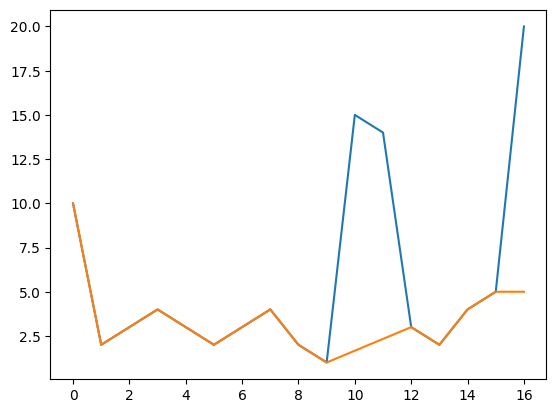

In [33]:
arr=np.array([10,2,3,4,3,2,3,4,2,1,15,14,3,2,4,5,20])
plt.plot(range(len(arr)),arr)
mean=np.mean(arr)
print(mean)
arr=np.where(arr>2*mean,np.nan,arr)
print(arr)
not_nan=np.where (arr!= np.nan)
ix=np.arange(len(arr))

arr2=np.interp(ix,ix[not_nan],arr[not_nan])
arr2=pd.Series(arr).interpolate()
print(arr2)

plt.plot(range(len(arr2)),arr2)

In [67]:
data={1:np.array([4,2,3,3,2,1,2,32,1,40]),2:np.array([40,1,2,3,1,4,2,1,3,2])*100}

frame=pd.DataFrame(data)
print(frame)
frame[:]=frame[:].where(abs(frame[:])< frame[:].std(),np.nan)
print(frame)
frame.interpolate()
frame.interpolate()

    1     2
0   4  4000
1   2   100
2   3   200
3   3   300
4   2   100
5   1   400
6   2   200
7  32   100
8   1   300
9  40   200
     1      2
0  4.0    NaN
1  2.0  100.0
2  3.0  200.0
3  3.0  300.0
4  2.0  100.0
5  1.0  400.0
6  2.0  200.0
7  NaN  100.0
8  1.0  300.0
9  NaN  200.0


,1,2
0,4.0,NaN
1,2.0,100.0
2,3.0,200.0
3,3.0,300.0
4,2.0,100.0
5,1.0,400.0
6,2.0,200.0
7,1.5,100.0
8,1.0,300.0
9,1.0,200.0


### Note to self: 
kjør cellen under, men fjern kvalitetskrav på vinddata. lagre i egen mappe for data med dårlig vind-kvalitet

In [11]:
# convert_folder("D:/ProcessedData_Hardanger_mat",path_out="D:/data_disk/resampl/",sorting_crit='-' )

In [2]:
# pd.to_pickle(dataframe,'test_frame')
matplotlib.use('tkagg')
test=H1_east.get('raw_data')[1]
# print(test)
test=scipy.signal.detrend(test)

# def plot_signal(signal)
fig=plt.figure(figsize=(20,5))
t=np.linspace(0,dur,len(test))
plt.plot(t,test,linewidth=0.2,label='signal 200 Hz',alpha=0.5)
plt.axhline(0,linewidth=0.2,linestyle='--',color='black',zorder=-1)


resampled=sp.signal.decimate(test,10)
resampled_2=sp.signal.decimate(resampled,4)
resampled_3=sp.signal.decimate(test,40)

re_t=np.linspace(0,dur,len(resampled))
re_t_2=np.linspace(0,dur,len(resampled_2))

# t_fra_df=np.linspace(0,dur,len(d))

plt.plot(dataframe['timeseries'],dataframe['H1 East_y'],linewidth=0.5,label='resampled to 5 Hz, detrend 10 min')
# plt.plot(re_t,resampled,linewidth=0.4,marker='.',markersize=0.4,label='resampled 20Hz',zorder=1)
# plt.plot(re_t_2,resampled_2,linewidth=0.4,marker='.',markersize=0.4,label='resampled again 5Hz',zorder=1)
plt.plot(re_t_2,resampled_2,linewidth=0.4,marker='.',markersize=0.4,label='resampled to 5Hz, detrend 30 min',zorder=1)
start=0
xrange=100
# plt.ylim(-0.002,0.002)
# plt.xlim(start,start+xrange)



H1_east_dt=scipy.signal.detrend(H1_east.get('adjusted_data')[1])
t_comparison=np.linspace(0,dur,len(H1_east_dt))
plt.plot(t_comparison,-1*H1_east_dt,linewidth=0.4,label='auto 20 Hz from recording file',zorder=-2)
plt.legend(loc='upper left')
plt.show()

NameError: name 'H1_east' is not defined